In [5]:
import sys
sys.path.append('..')

import os

from spp import process
from spp import market
import numpy as np
import pandas as pd
import math
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [6]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

class CustomStockDataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.longlong).flatten()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_data(ticker, start, end, window_size, test_coef, pipeline=process.HistBinPipeline):
    """
    tickers, end="2022-06-01", start="2020-06-01", test_coef=1/2/6, window_size=window_size
    """
    CHANNELS = 5
    pipe = pipeline(ticker, end=end, start=start, test_coef=test_coef, window_size=window_size)
    X_train, y_train, X_valid, y_valid, X_test, y_test = pipe.get_data()
    
    ori_test_len = len(y_test)
    
    X_train = X_train[:len(X_train) // 8 * 8]
    X_valid = X_valid[:len(X_valid) // 8 * 8]
    X_test = X_test[:len(X_test) // 8 * 8]

    y_train = y_train[:len(y_train) // 8 * 8]
    y_valid = y_valid[:len(y_valid) // 8 * 8]
    y_test = y_test[:len(y_test) // 8 * 8]
    
    X_train[[f"RSI_{i}" for i in range(window_size-1)]] /= 100
    if len(X_valid) > 0:
        X_valid[[f"RSI_{i}" for i in range(window_size-1)]] /= 100
    if len(X_test) > 0:
        X_test[[f"RSI_{i}" for i in range(window_size-1)]] /= 100
    
    training_data = CustomStockDataset(X_train, y_train)
    valid_data = CustomStockDataset(X_valid, y_valid)
    test_data = CustomStockDataset(X_test, y_test)
    
    pt = pipe._get_price_true(2)

    train_dataloader = DataLoader(training_data, batch_size=8, shuffle=False, drop_last=True)
    valid_dataloader = DataLoader(valid_data, batch_size=8, shuffle=False, drop_last=True)
    test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False, drop_last=True)
    return train_dataloader, valid_dataloader, test_dataloader, X_train, y_train, X_valid, y_valid, X_test, y_test, pt[:len(y_test)]

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

import matplotlib.pyplot as plt

import copy

class forecasting_model(nn.Module):
    
    def __init__(self, input_features, output_features, print_shapes = False):
        super().__init__()
        self.conv    = nn.Conv1d(in_channels = input_features, out_channels = 128, kernel_size = 3, padding = 1)
        self.pool1   = nn.AdaptiveAvgPool1d(1)
        self.pool2   = nn.AdaptiveMaxPool1d(1)
        self.flatten = nn.Flatten()
        self.bn      = nn.BatchNorm1d(num_features = 2 * 128)
        self.relu    = nn.ReLU()
        self.fc      = nn.Linear(in_features = 2 * 128, out_features = output_features)
        self.print_shapes = print_shapes
        
    def forward(self, x):
        
        if self.print_shapes: print(f"{'Input Batch Shape':<25} {x.shape}")
        
        conv_op = self.conv(x)
        if self.print_shapes: print(f"{'Conv Output Shape':<25} {conv_op.shape}")
        
        avg_pool = self.pool1(conv_op)
        max_pool = self.pool2(conv_op)
        final_pool = torch.cat([avg_pool, max_pool], dim = -1)
        flattened_op = self.flatten(final_pool)
        if self.print_shapes: print(f"{'Pooled Output Shape':<25} {flattened_op.shape}")
        
        final_op = self.fc(self.bn(self.relu(flattened_op)))
        if self.print_shapes: print(f"{'Output Shape':<25} {final_op.shape}")
            
        return final_op
    
class TorchModel:
    def __init__(self, model, window_size):
        self.model = model
        self.window_size = window_size
        self.batch_size = 8

    def fit(self, x_data, y_data):
        return self

    def predict_dl(self, dataloader):
        y_preds = []
        with torch.no_grad():
            predicred_true = 0
            for i, data in enumerate(dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                outputs = self.model(inputs.reshape([inputs.shape[0], CHANNELS, self.window_size-1]))
                y_preds += torch.argmax(outputs, dim=1).tolist()

#                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
#             train_loss.append(running_loss / step)

        return pd.DataFrame(y_preds)

    def predict(self, data_ext):
        add_count = 0
        if len(data_ext) % self.batch_size != 0:
            add_count = self.batch_size - len(data_ext) % self.batch_size
        ori_len = len(data_ext)
        data = copy.deepcopy(data_ext)
        for i in range(add_count):
            data = data.append(data.iloc[0], ignore_index=True)
            
        
        dataset = CustomStockDataset(data, [-1 for i in range(len(data))])
        dataloader = DataLoader(dataset, batch_size=8, shuffle=False, drop_last=False)
        return self.predict_dl(dataloader)[:ori_len]
    
    def score_dl(self, x_dataloader, y_data):
        if len(y_data) != len(x_dataloader.dataset):
            raise Exception("Different data length")
#         print(np.array(self.predict(x_dataloader)).flatten() == np.array(y_data).flatten())
        return sum(np.array(self.predict_dl(x_dataloader)).flatten() == np.array(y_data).flatten()) / len(y_data)

    def score(self, x_data, y_data):
        if len(y_data) != len(x_data):
            raise Exception("Different data length")
#         print(np.array(self.predict(x_dataloader)).flatten() == np.array(y_data).flatten())
        return sum(np.array(self.predict(x_data)).flatten() == np.array(y_data).flatten()) / len(y_data)
    
    
class ModelTrainer:
    def __init__(self, window_size):
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD
        self.train_loss = []
        self.valid_loss = []
        self.test_acc = []
        
        self.window_size = window_size

        self.save_history = []

        self.best_model = None
        self.best_acc = 0
        self.torch_model = forecasting_model(CHANNELS, 2, False)
    
    def train_model(self, train_dataloader, valid_dataloader, test_dataloader, epoch=150):
        
        criterion = self.criterion
        torch_model = self.torch_model
        optimizer = self.optimizer(torch_model.parameters(), lr = 3e-3, momentum=0.9)
        train_loss = self.train_loss
        valid_loss = self.valid_loss
        test_acc = self.test_acc
        save_history = self.save_history 
        best_model = self.best_model 
        best_acc = self.best_acc
        window_size = self.window_size
        
        for epoch in range(epoch):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(train_dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                # outputs = model(inputs.reshape([inputs.shape[0], 2, window_size-1]))
                outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, window_size-1]))
        #         print(outputs.shape, labels)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                step = len(train_dataloader)
                if i % step == step - 1: 

                    with torch.no_grad():
                        predicred_true = 0
                        for i, data in enumerate(train_dataloader, 0):
                            # get the inputs; data is a list of [inputs, labels]
                            inputs, labels = data
                            outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, window_size-1]))
                            predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

        #                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                        train_loss.append(predicred_true/ len(train_dataloader.dataset))
        #             train_loss.append(running_loss / step)

                    with torch.no_grad():
                        predicred_true = 0
                        for i, data in enumerate(test_dataloader, 0):
                            # get the inputs; data is a list of [inputs, labels]
                            inputs, labels = data
                            outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, window_size-1]))
        #                     print("Output", outputs)
        #                     print("Output", torch.argmax(outputs, dim=1))
        #                     print("labels", labels)
                            predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

        #                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                        test_acc.append(predicred_true/ len(test_dataloader.dataset))

                    predicred_true = 0
                    with torch.no_grad():
                        for i, data in enumerate(valid_dataloader, 0):
                            # get the inputs; data is a list of [inputs, labels]
                            inputs, labels = data
                            outputs = torch_model(inputs.reshape([inputs.shape[0], CHANNELS, window_size-1]))
        #                     print("Output", outputs)
        #                     print("Output", torch.argmax(outputs, dim=1))
        #                     print("labels", labels)
                            predicred_true += int(sum(torch.argmax(outputs, dim=1) == labels.flatten()))

        #                 print(f"test acc: {predicred_true/ len(test_dataloader.dataset):.3f}", end="")
                        valid_loss.append(predicred_true/ len(test_dataloader.dataset))

                    print(f'\r[{epoch + 1}, {i + 1:5d}] loss: {running_loss / step:.3f} | test acc: {test_acc[-1]:.3f} | valid acc: {valid_loss[-1]:.3f} | train acc {train_loss[-1]:.3f}', end='', flush=True)
                    running_loss = 0.0

                    if predicred_true / len(test_dataloader.dataset) > best_acc:
                        best_model = copy.deepcopy(torch_model)
                        best_acc = predicred_true/ len(test_dataloader.dataset)

                    save_history.append(best_acc)

        plt.plot(train_loss, label="train_acc")
        plt.plot(valid_loss, label="valid_acc")
        plt.plot(test_acc, label="test_acc")
        plt.plot(save_history, label="save_history")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        self.best_acc = best_acc
        self.best_model = best_model 

        print('Finished Training')

In [8]:
# for pandas future deprecated
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

import copy

CHANNELS = 5

def grid_search_cnn(window_sizes = [14,15,16], month_counts=[24]):
    tickers = ["CMCSA"]
    end="2022-06-01"
    max_cap = 0
    best_params = None
    best_global_model = None
    
    grid = [[None for i in range(len(month_counts))] for j in range(len(window_sizes))]
    
    for i, window_size in enumerate(window_sizes):
        for j, month_count in enumerate(month_counts):
            start = (parse(end) - relativedelta(months=12+month_count)).strftime("%Y-%m-%d")
            test_coef = 12 / (12 + month_count)

            train_dataloader, _, test_dataloader, X_train, y_train, X_valid, y_valid, X_test, y_test, y_test_price = get_data(tickers, 
                                                                                      end=end, 
                                                                                      start=start, 
                                                                                      test_coef=test_coef, 
                                                                                      window_size=window_size,
                                                                                      pipeline=process.HistBinPipeline0Valid)
            mt = ModelTrainer(window_size)
            mt.train_model(train_dataloader, test_dataloader, test_dataloader, epoch=70)
            best_model = mt.best_model
            
            model = TorchModel(best_model, window_size)

            y_train_pred_bin = model.predict(X_test)
            
            cap = 100000
            btt = market.BinTraderTest(cap, y_train_pred_bin, y_test_price)
            
            new_cap = btt.trade()
            if new_cap > max_cap:
                max_cap = new_cap
                best_params = {"wsize": window_size, "mon": month_count, "cap": max_cap}
                best_global_model = best_model
            
            grid[i][j] = new_cap
            
            print(f"[INFO] {month_count}: from {start} to '2021-06-01'; test_coef: {test_coef}; {new_cap-cap}$")
    return (best_params, best_global_model, grid)

[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.341 | test acc: 0.609 | valid acc: 0.609 | train acc 0.908

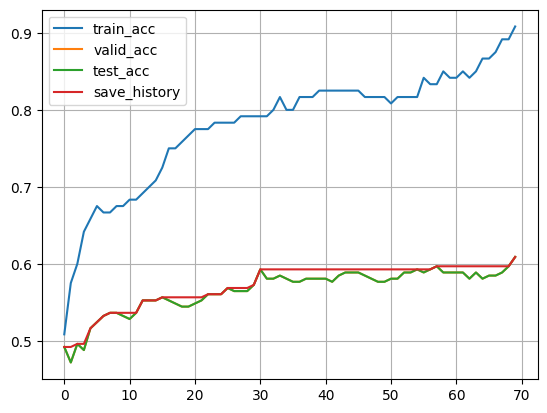

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [21322.45642743]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.473 | test acc: 0.621 | valid acc: 0.621 | train acc 0.718

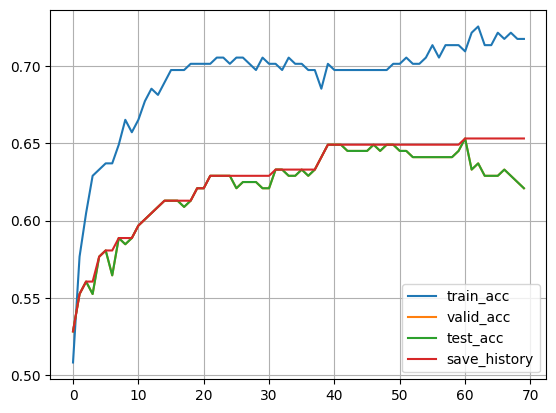

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [54537.56301068]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.474 | test acc: 0.593 | valid acc: 0.593 | train acc 0.742

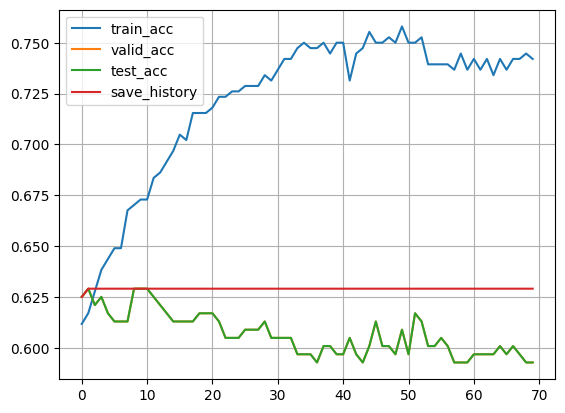

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [24010.64041905]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.531 | test acc: 0.577 | valid acc: 0.577 | train acc 0.722

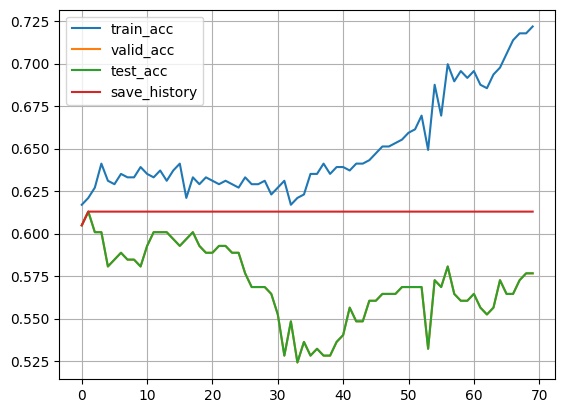

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [8216.87511671]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.537 | test acc: 0.601 | valid acc: 0.601 | train acc 0.707

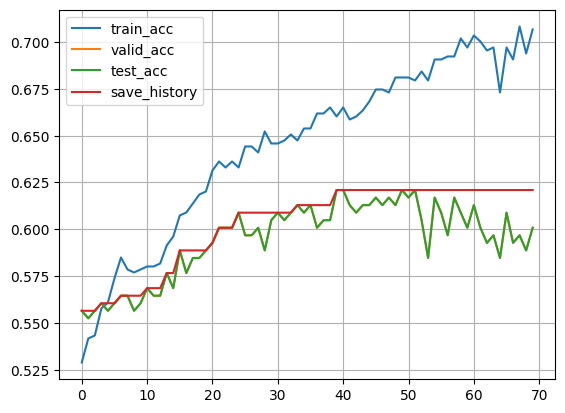

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [29053.64386339]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.538 | test acc: 0.601 | valid acc: 0.601 | train acc 0.688

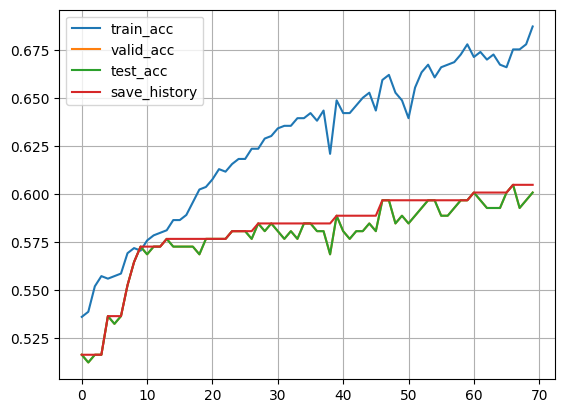

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [33685.74712283]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.542 | test acc: 0.601 | valid acc: 0.601 | train acc 0.696

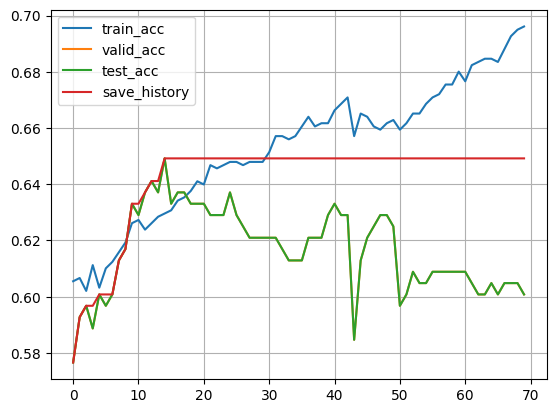

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [34733.48037203]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.244 | test acc: 0.633 | valid acc: 0.633 | train acc 0.925

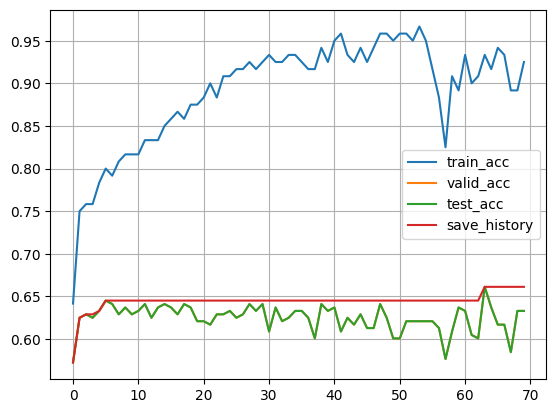

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [28856.70094257]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.296 | test acc: 0.589 | valid acc: 0.589 | train acc 0.887

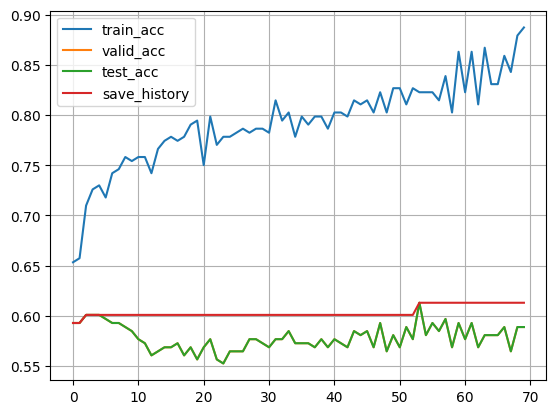

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [7084.70476419]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.303 | test acc: 0.597 | valid acc: 0.597 | train acc 0.842

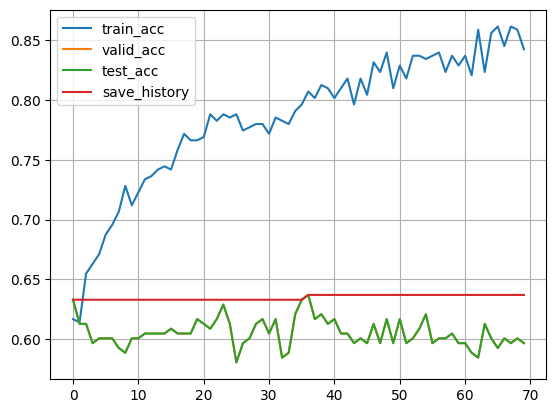

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [23728.78837605]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.365 | test acc: 0.593 | valid acc: 0.593 | train acc 0.821

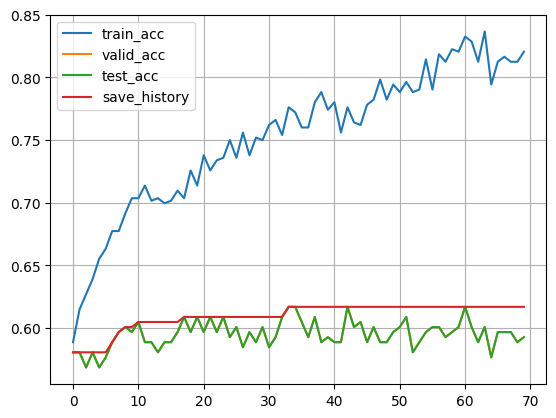

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [8365.9628229]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.393 | test acc: 0.625 | valid acc: 0.625 | train acc 0.803

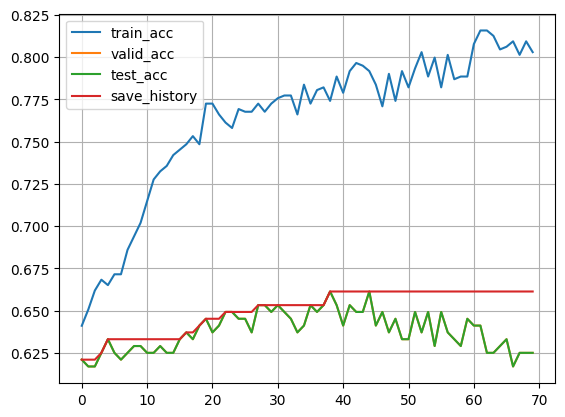

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [16651.71262741]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.447 | test acc: 0.625 | valid acc: 0.625 | train acc 0.774

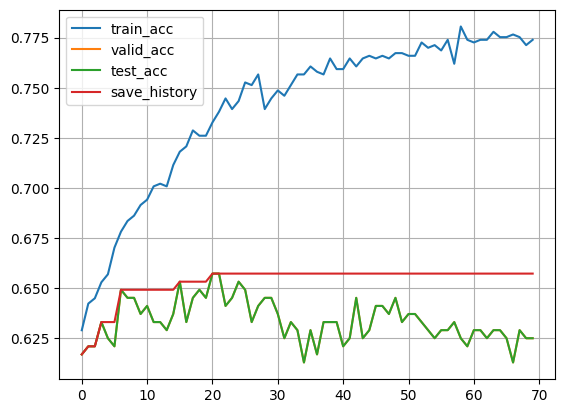

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [18626.27428808]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.484 | test acc: 0.617 | valid acc: 0.617 | train acc 0.767

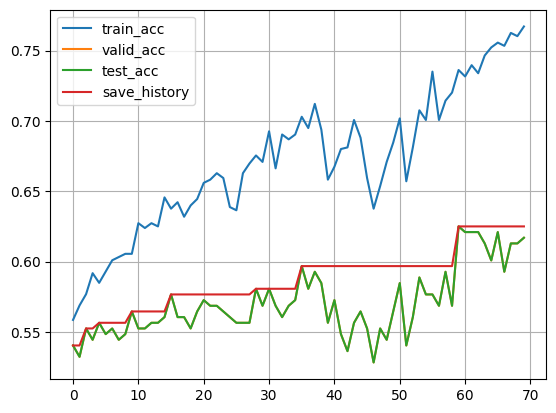

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [20936.54601351]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.124 | test acc: 0.658 | valid acc: 0.658 | train acc 0.942

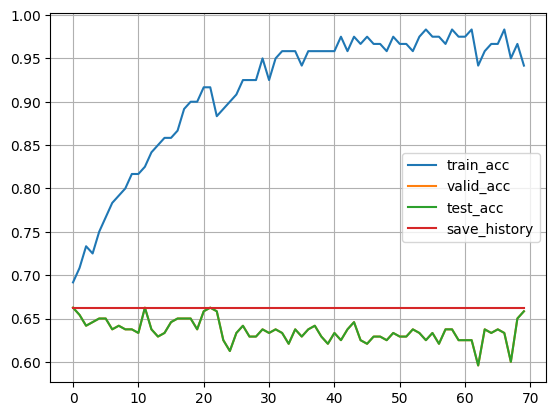

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [45866.96775276]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.258 | test acc: 0.609 | valid acc: 0.609 | train acc 0.895

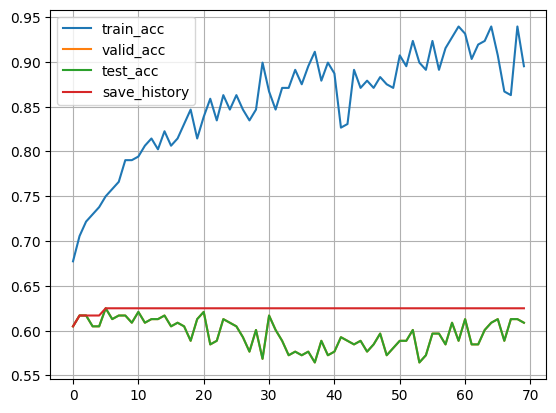

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [5557.45399589]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.272 | test acc: 0.569 | valid acc: 0.569 | train acc 0.908

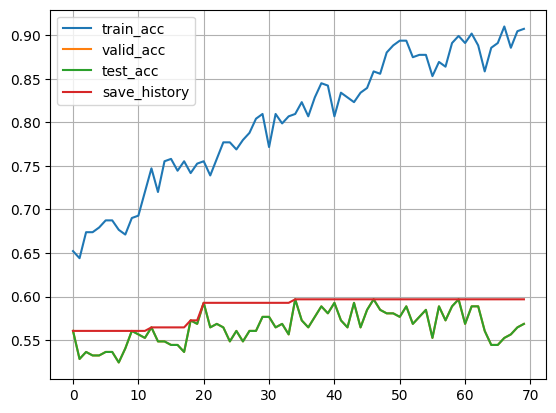

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [24445.66508528]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.375 | test acc: 0.548 | valid acc: 0.548 | train acc 0.837

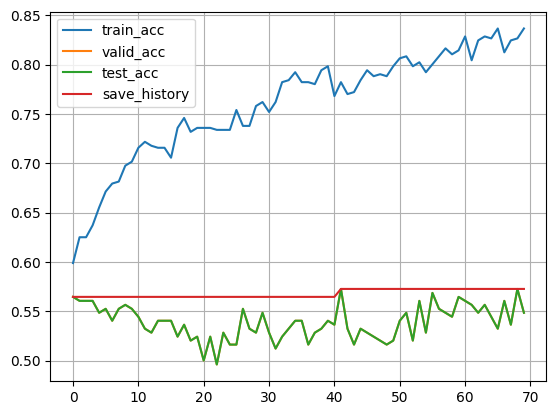

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [17180.25257577]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.357 | test acc: 0.613 | valid acc: 0.613 | train acc 0.864

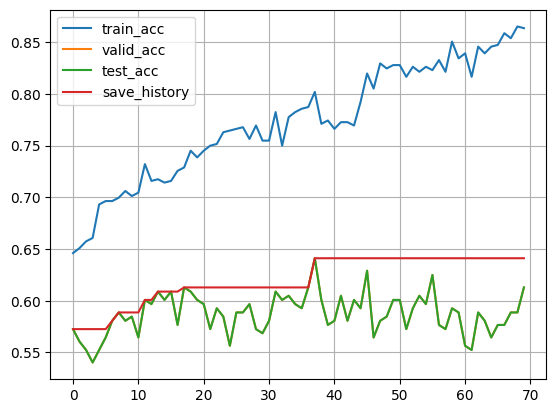

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [20438.73698655]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.477 | test acc: 0.565 | valid acc: 0.565 | train acc 0.777

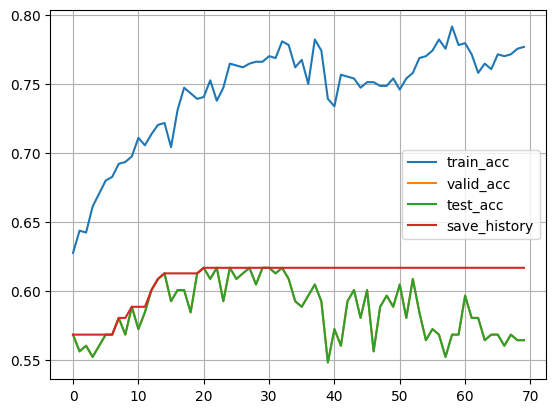

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [17785.87603448]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.478 | test acc: 0.573 | valid acc: 0.573 | train acc 0.774

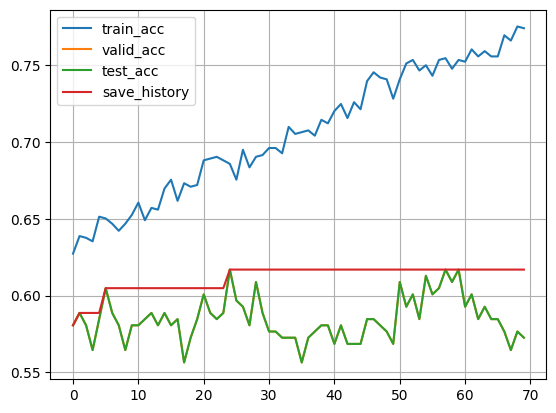

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [19562.7108838]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.190 | test acc: 0.637 | valid acc: 0.637 | train acc 0.975

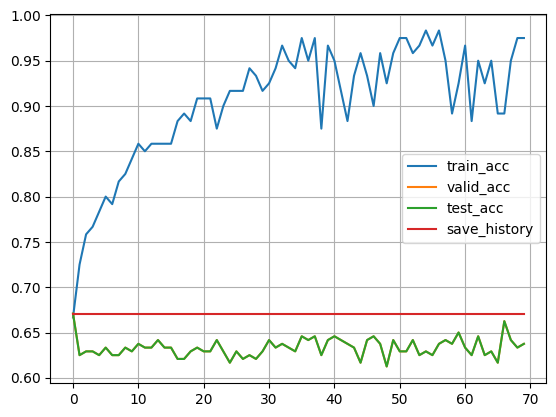

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [15939.58296728]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.211 | test acc: 0.625 | valid acc: 0.625 | train acc 0.927

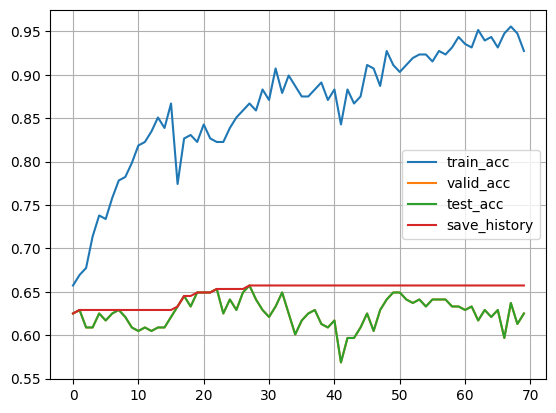

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [13914.40916069]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.281 | test acc: 0.556 | valid acc: 0.556 | train acc 0.897

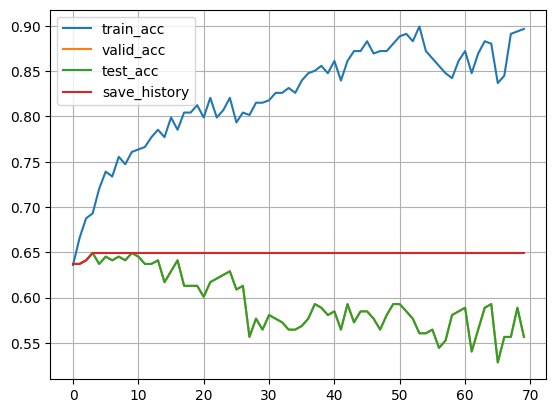

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [13709.49429783]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.373 | test acc: 0.661 | valid acc: 0.661 | train acc 0.835

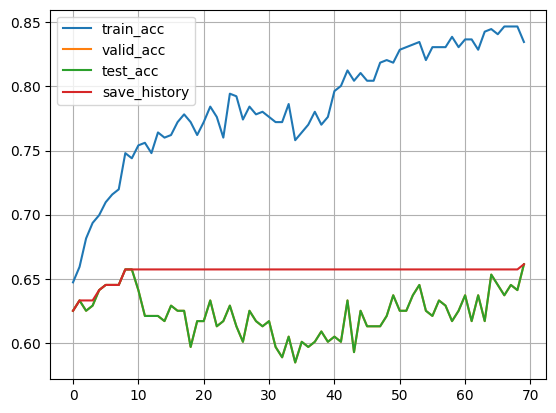

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [18239.42405418]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.369 | test acc: 0.556 | valid acc: 0.556 | train acc 0.838

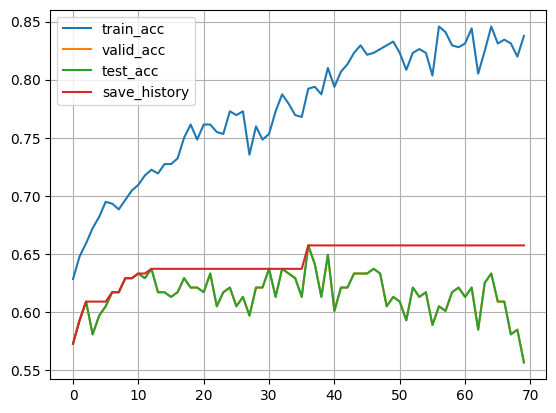

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [45087.64850638]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.414 | test acc: 0.617 | valid acc: 0.617 | train acc 0.808

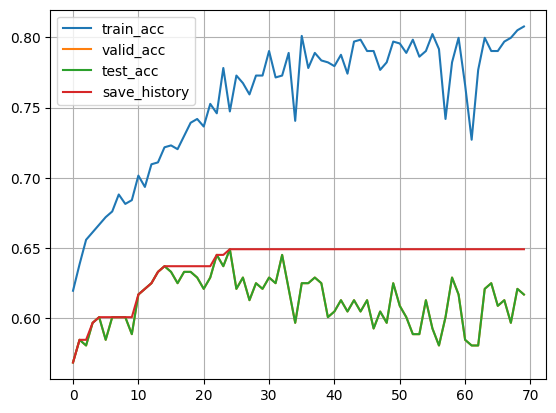

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [22887.93546279]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.417 | test acc: 0.633 | valid acc: 0.633 | train acc 0.808

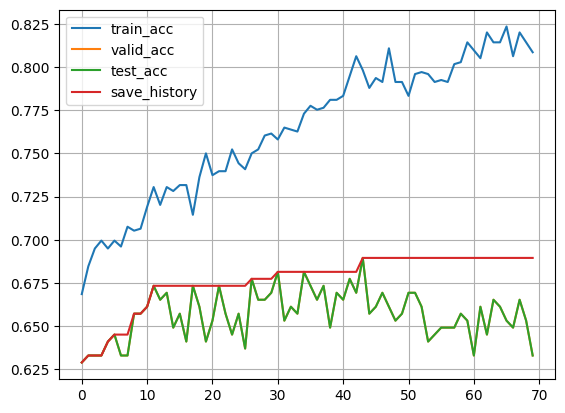

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [14960.75992917]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.163 | test acc: 0.575 | valid acc: 0.575 | train acc 0.967

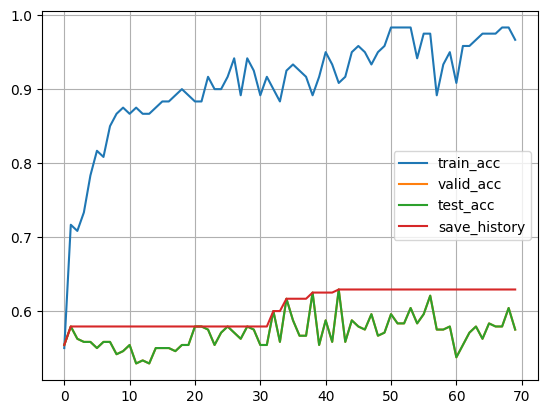

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [13796.11229704]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.161 | test acc: 0.621 | valid acc: 0.621 | train acc 0.975

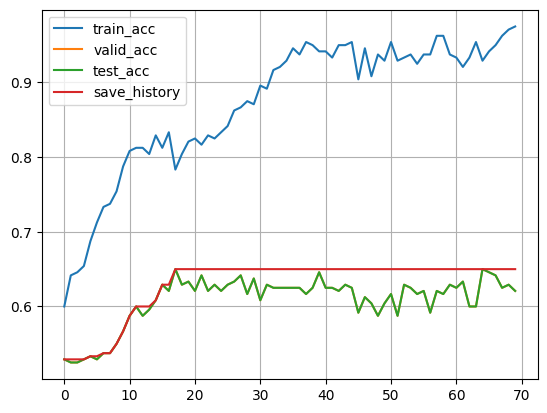

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [51780.55381885]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.296 | test acc: 0.625 | valid acc: 0.625 | train acc 0.891

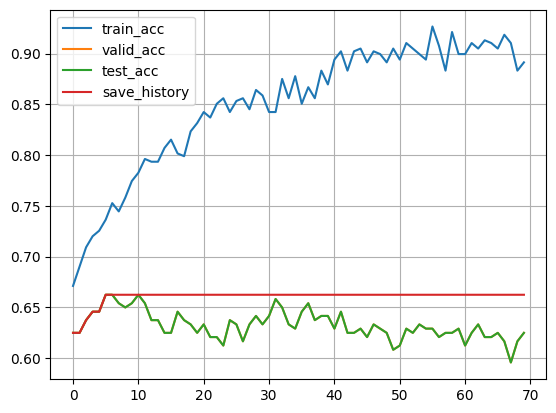

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [13716.77429175]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.336 | test acc: 0.548 | valid acc: 0.548 | train acc 0.873

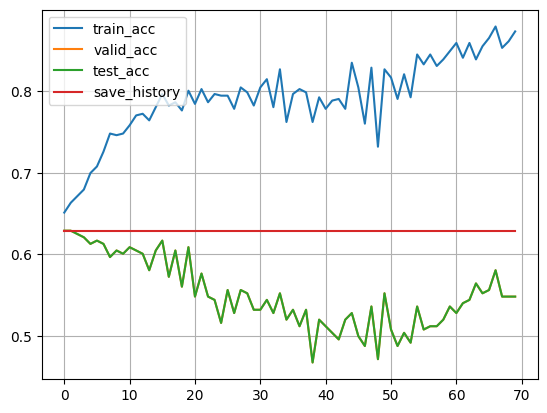

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [-2822.14337278]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.424 | test acc: 0.637 | valid acc: 0.637 | train acc 0.818

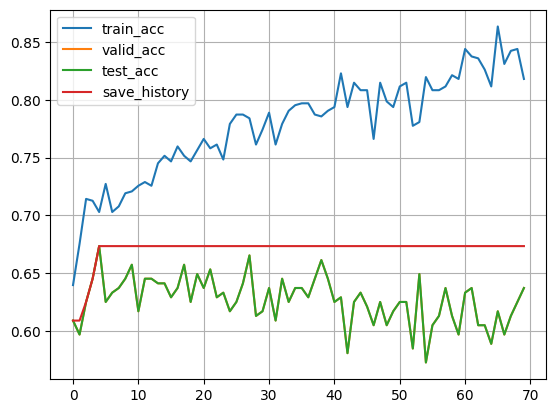

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [14118.81098465]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.454 | test acc: 0.569 | valid acc: 0.569 | train acc 0.782

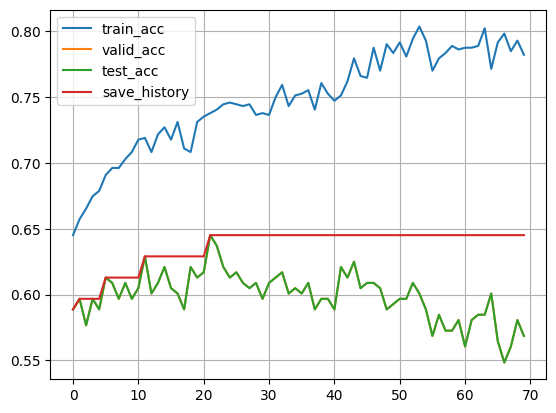

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [24479.71486552]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.504 | test acc: 0.641 | valid acc: 0.641 | train acc 0.757

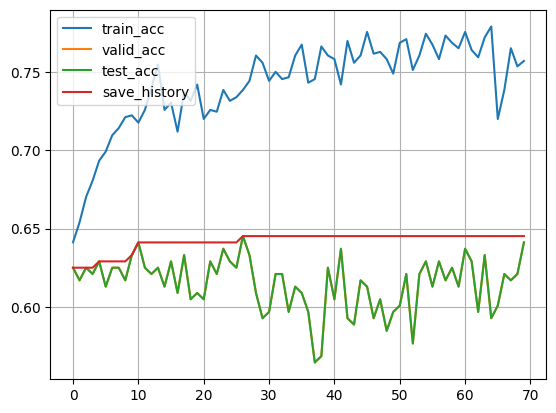

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [16224.64977371]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.183 | test acc: 0.583 | valid acc: 0.583 | train acc 0.975

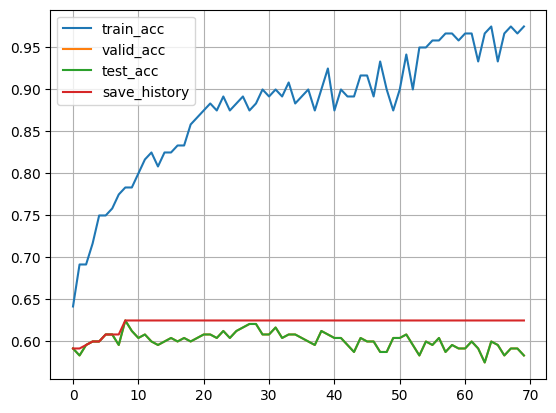

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [6757.58138049]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.343 | test acc: 0.567 | valid acc: 0.567 | train acc 0.892

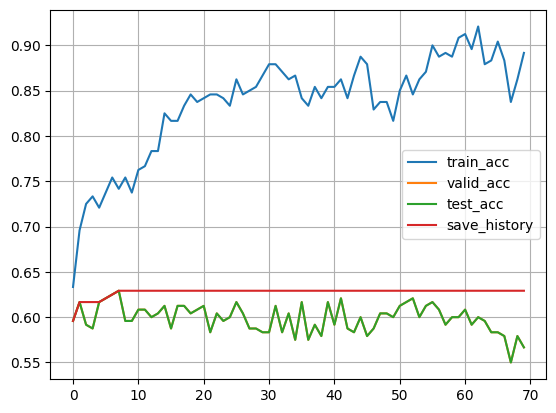

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [22304.33951291]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.293 | test acc: 0.625 | valid acc: 0.625 | train acc 0.880

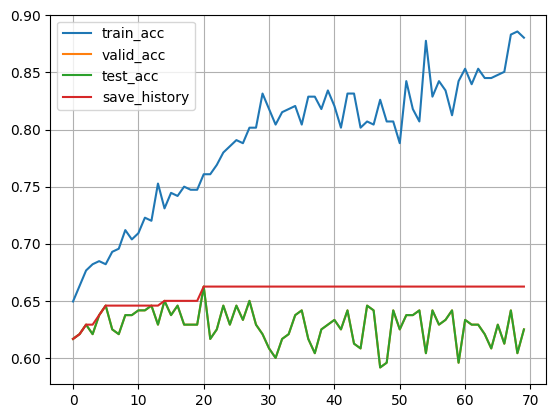

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [31272.76678198]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.384 | test acc: 0.593 | valid acc: 0.593 | train acc 0.824

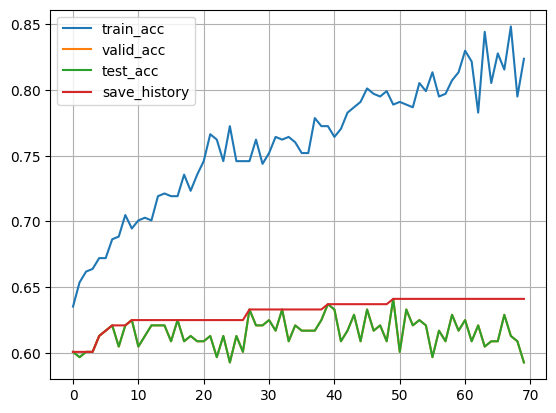

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [-13347.54996762]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.391 | test acc: 0.579 | valid acc: 0.579 | train acc 0.828

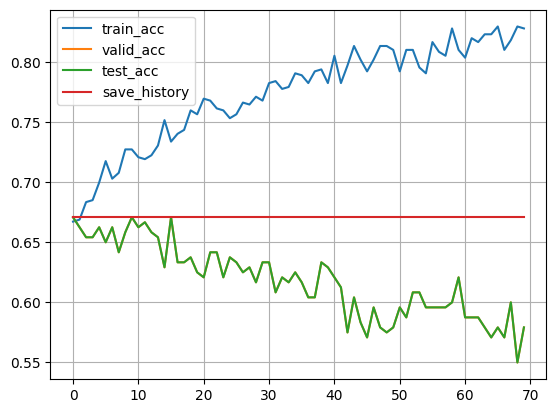

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [36675.19860785]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.428 | test acc: 0.613 | valid acc: 0.613 | train acc 0.793

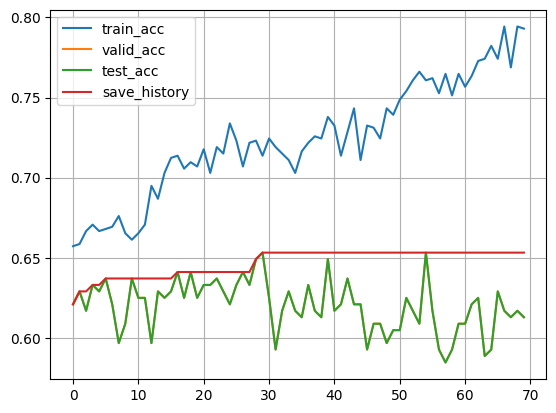

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [-4568.02233329]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.451 | test acc: 0.605 | valid acc: 0.605 | train acc 0.801

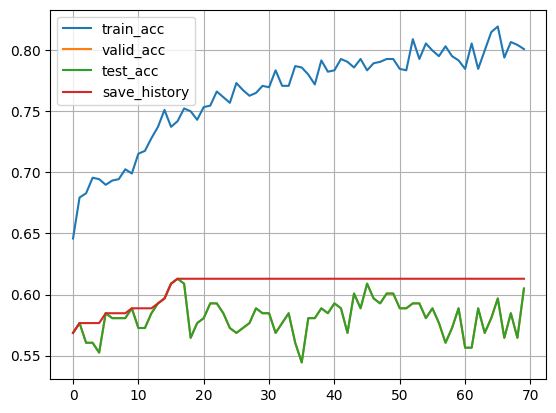

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [18449.3071851]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.119 | test acc: 0.579 | valid acc: 0.579 | train acc 1.000

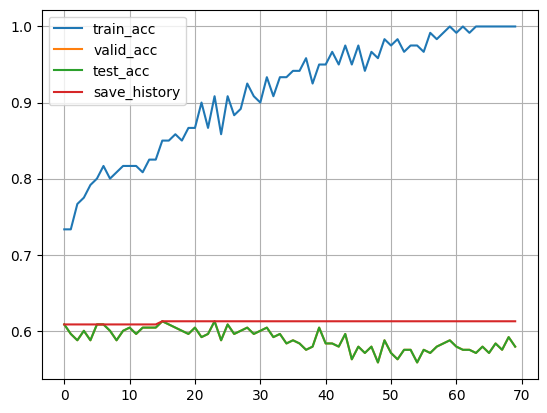

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [4299.75536895]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.216 | test acc: 0.650 | valid acc: 0.650 | train acc 0.942

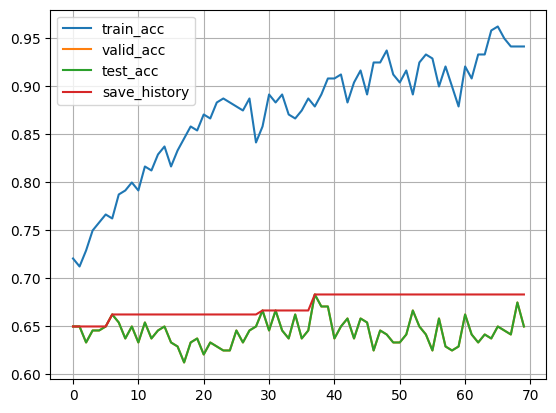

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [25528.79674818]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.403 | test acc: 0.592 | valid acc: 0.592 | train acc 0.842

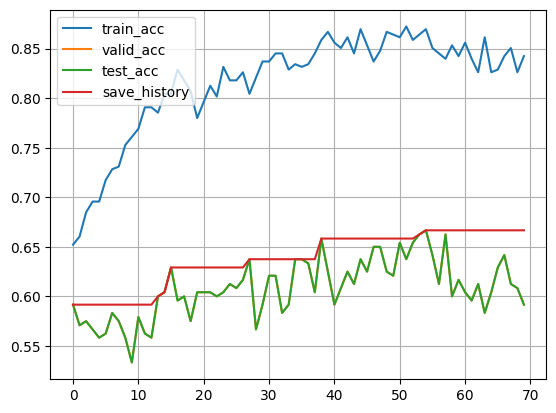

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [53713.79584602]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.445 | test acc: 0.613 | valid acc: 0.613 | train acc 0.801

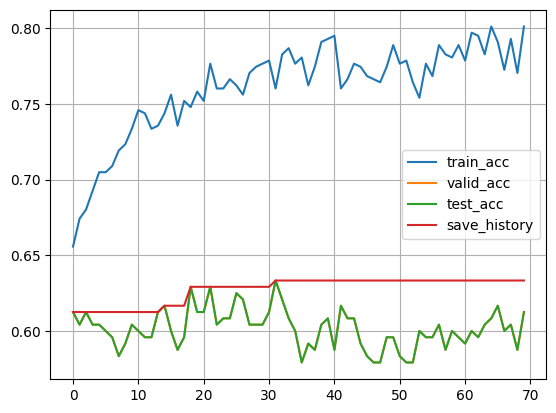

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [18277.41282766]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.418 | test acc: 0.633 | valid acc: 0.633 | train acc 0.795

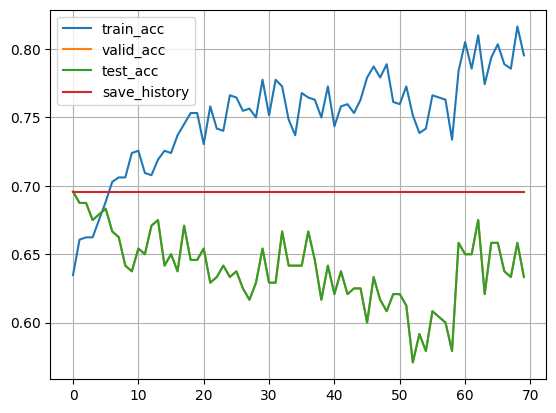

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [15000.36144509]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.428 | test acc: 0.653 | valid acc: 0.653 | train acc 0.825

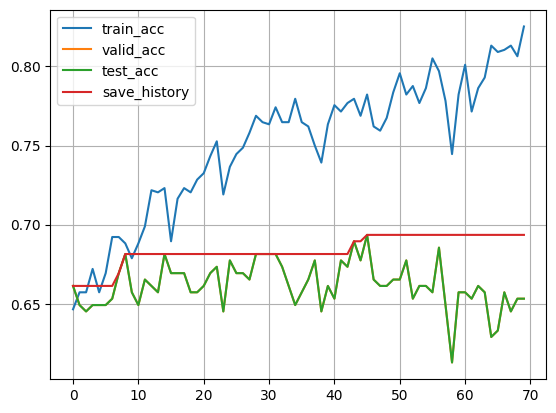

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [29181.07743334]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.508 | test acc: 0.637 | valid acc: 0.637 | train acc 0.774

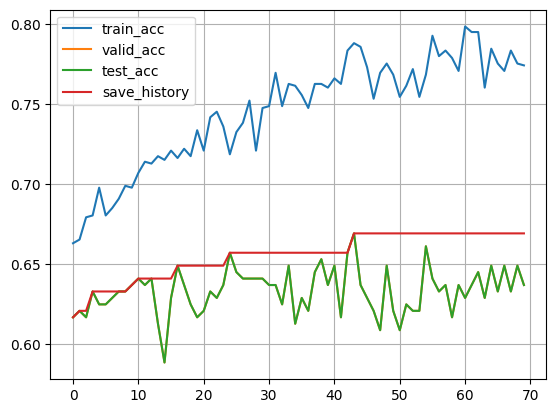

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [8286.61055686]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.311 | test acc: 0.604 | valid acc: 0.604 | train acc 0.900

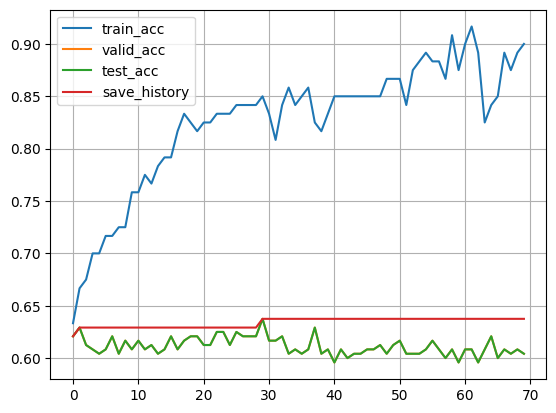

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [7232.69302722]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.286 | test acc: 0.617 | valid acc: 0.617 | train acc 0.896

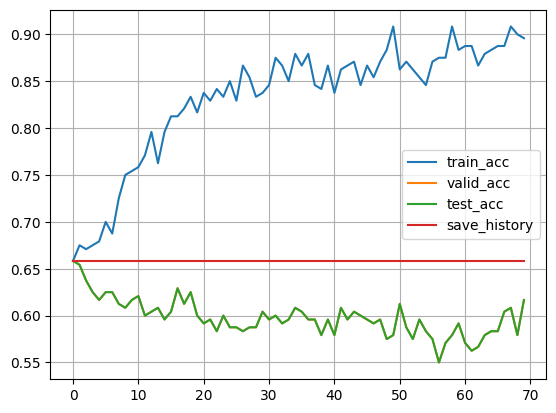

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [8233.92949473]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.343 | test acc: 0.600 | valid acc: 0.600 | train acc 0.861

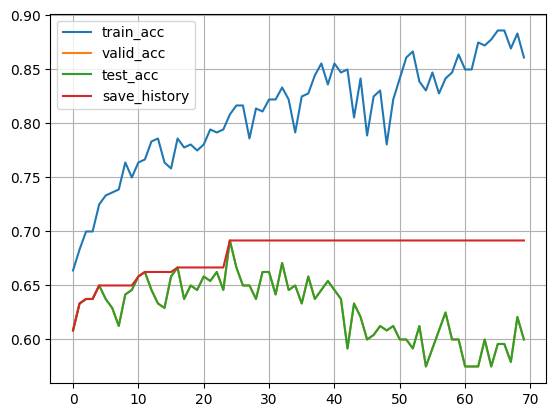

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [33891.55180042]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.372 | test acc: 0.629 | valid acc: 0.629 | train acc 0.857

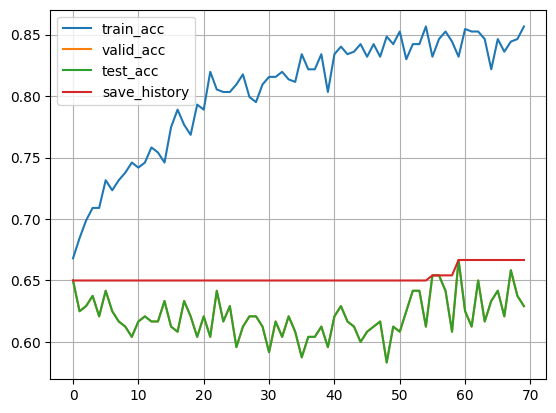

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [28924.67823923]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.498 | test acc: 0.588 | valid acc: 0.588 | train acc 0.795

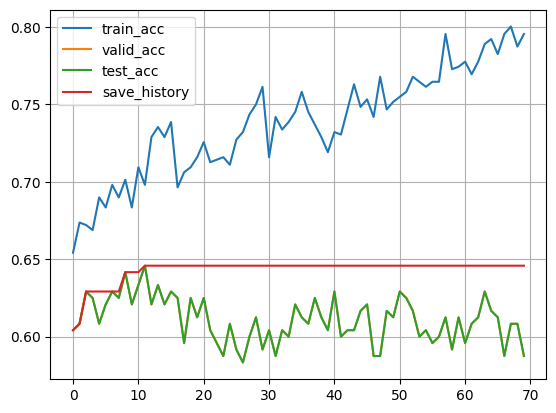

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [24706.39401739]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.518 | test acc: 0.625 | valid acc: 0.625 | train acc 0.740

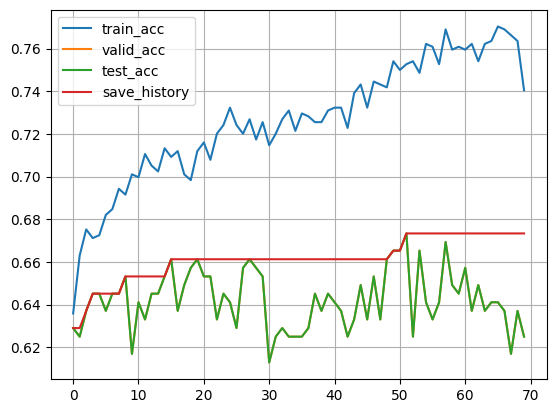

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [15697.55662334]$
[*********************100%***********************]  1 of 1 completed
[70,    31] loss: 0.517 | test acc: 0.690 | valid acc: 0.690 | train acc 0.751

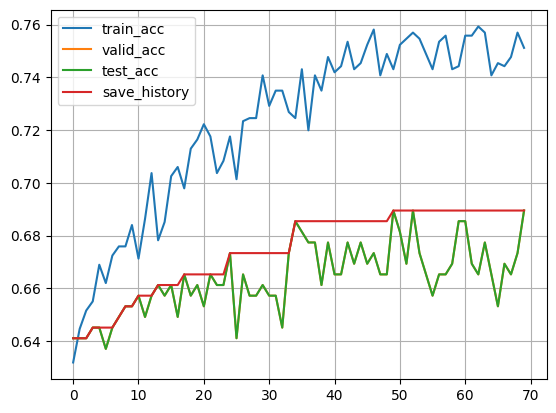

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [9837.77435987]$
[*********************100%***********************]  1 of 1 completed
[70,    29] loss: 0.266 | test acc: 0.565 | valid acc: 0.565 | train acc 0.929

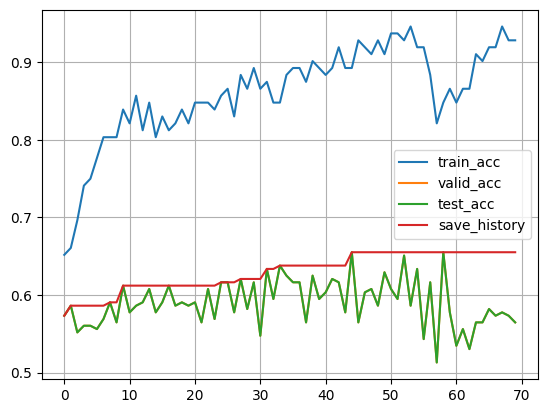

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [12567.12636907]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.407 | test acc: 0.567 | valid acc: 0.567 | train acc 0.833

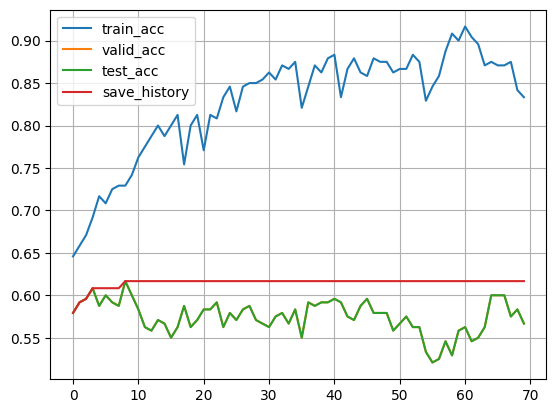

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [23261.12501661]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.268 | test acc: 0.608 | valid acc: 0.608 | train acc 0.942

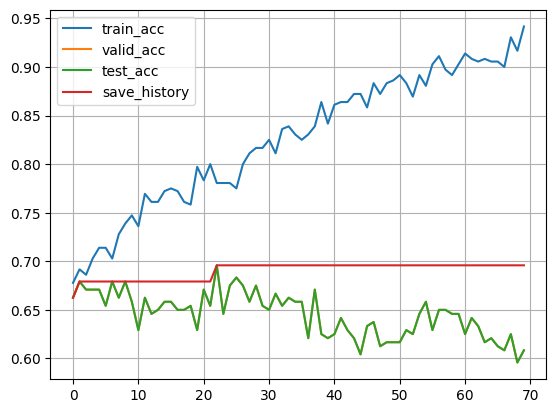

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [8058.94389676]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.424 | test acc: 0.554 | valid acc: 0.554 | train acc 0.801

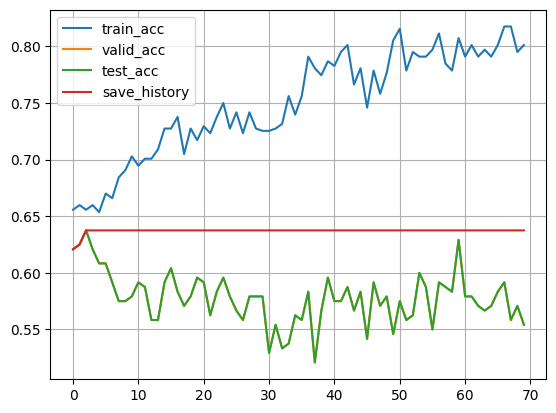

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [2441.71064499]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.476 | test acc: 0.529 | valid acc: 0.529 | train acc 0.765

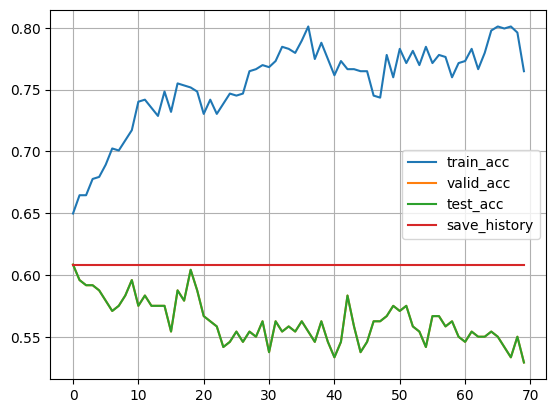

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [7880.74239795]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.476 | test acc: 0.658 | valid acc: 0.658 | train acc 0.796

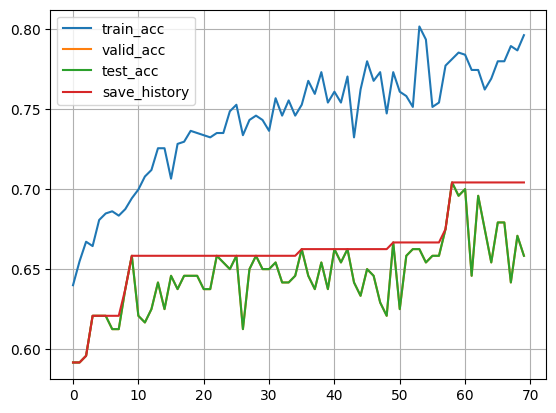

Finished Training
[INFO] 36: from 2018-06-01 to '2021-06-01'; test_coef: 0.25; [42981.65012214]$
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.466 | test acc: 0.617 | valid acc: 0.617 | train acc 0.772

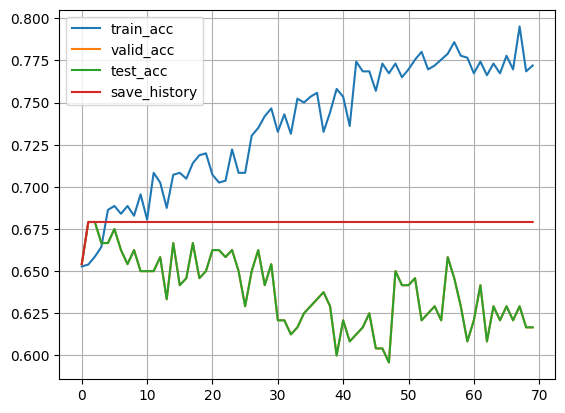

Finished Training
[INFO] 42: from 2017-12-01 to '2021-06-01'; test_coef: 0.2222222222222222; [23347.51135987]$


In [5]:
window_sizes = [i for i in range(4, 21, 2)]
month_counts = [6, 12, 18, 24, 30, 36, 42]

params, model, grid = grid_search_cnn(window_sizes, month_counts)

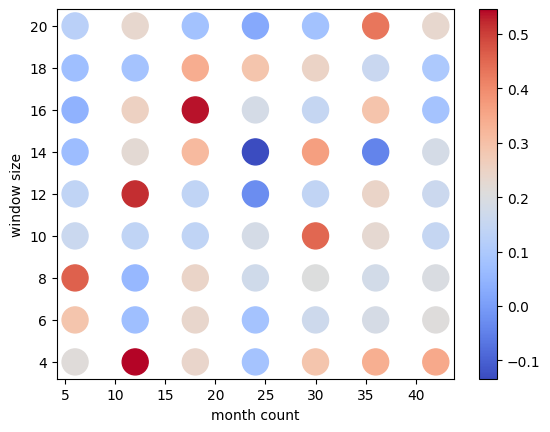

In [20]:
from matplotlib import cm
import numpy as np

fig = plt.figure()
plt.xlabel("month count")
plt.ylabel("window size")
# plt.contourf(month_counts, window_sizes, ( (np.array(grid) - 100000) / 100000 ).squeeze(), cmap=cm.coolwarm)
y = []
for item in window_sizes:
    y.append([item] * len(month_counts))
plt.scatter(month_counts*len(window_sizes), y, c=( (np.array(grid) - 100000) / 100000 ).squeeze(), s=350, cmap=cm.coolwarm)
plt.colorbar()

[*********************100%***********************]  1 of 1 completed
[70,    10] loss: 0.299 | test acc: 0.500 | valid acc: 0.562 | train acc 0.907

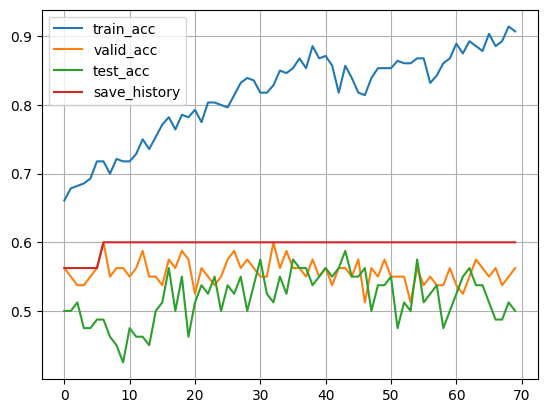

Finished Training


In [21]:
month_count = 18
window_size = 16

end="2022-06-01"
tickers = ["CMCSA"]

test_month_count = 2
valid_month_count = 2

mon_res = test_month_count + valid_month_count

start = (parse(end) - relativedelta(months=mon_res+month_count)).strftime("%Y-%m-%d")
test_coef = mon_res / (mon_res + month_count)

train_dataloader, valid_dataloader, test_dataloader, X_train, y_train, X_valid, y_valid, X_test, y_test, y_test_price = get_data(tickers, 
                                                                          end=end, 
                                                                          start=start, 
                                                                          test_coef=test_coef, 
                                                                          window_size=window_size,
                                                                          pipeline=process.HistBinPipeline)
mt = ModelTrainer(window_size)
mt.train_model(train_dataloader, valid_dataloader, test_dataloader, epoch=70)
model = mt.best_model

In [26]:
tmodel = TorchModel(model, window_size)
tickers = ["CMCSA"]

byt = market.BinYearTest(tickers, process.HistBinPipeline, end_date=None, window_size=window_size)
# orig_stdout = sys.stdout
# orig_stderr = sys.stderr
# f = open(os.devnull, 'w')
# sys.stdout = f
# sys.stderr = f
year_test_df = byt.trade(tmodel)
# sys.stdout = orig_stdout
# sys.stderr = orig_stderr

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


In [27]:
year_test_df

Month  TrainAcc   TestAcc    Income  Potential
0   Jun_2022  0.514768  0.625000  1.035848   0.572870
1   Jul_2022  0.481013  0.470588  0.974312  -0.295367
2   Aug_2022  0.525424  0.500000  0.977617  -0.367546
3   Sep_2022  0.489451  0.611111  1.008681   0.073607
4   Oct_2022  0.497890  0.555556  1.067916   1.057333
5   Nov_2022  0.538136  0.705882  1.062132   0.599592
6   Dec_2022  0.481013  0.666667  1.027451   0.340493
7   Jan_2023  0.502110  0.600000  1.008533   0.119757
8   Feb_2023  0.500000  0.500000  0.998371  -0.040782
9   Mar_2023  0.584746  0.722222  1.019508   0.311574
10  Apr_2023  0.542373  0.388889  1.000185   0.001324
11  May_2023  0.510638  0.588235  0.988921  -0.309973

In [28]:
from functools import reduce
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print("Year capital multiplier", reduced_income)
reduced_income

Year capital multiplier 1.1776276190744208


1.1776276190744208

In [33]:
torch.save(model, "cmcsa_model_16_18.pt")

### Clique prediction

In [29]:
# tmodel = TorchModel(model, params['wsize'])
tickers = ["EBAY"]

byt = market.BinYearTest(tickers, process.HistBinPipeline, end_date=None, window_size=window_size)
# orig_stdout = sys.stdout
# orig_stderr = sys.stderr
# f = open(os.devnull, 'w')
# sys.stdout = f
# sys.stderr = f
year_test_df = byt.trade(tmodel)
# sys.stdout = orig_stdout
# sys.stderr = orig_stderr

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


In [30]:
year_test_df

Month  TrainAcc   TestAcc    Income  Potential
0   Jun_2022  0.510549  0.687500  1.041873   0.293440
1   Jul_2022  0.438819  0.529412  1.055302   0.376407
2   Aug_2022  0.436441  0.388889  0.953833  -0.587303
3   Sep_2022  0.451477  0.444444  1.022297   0.250118
4   Oct_2022  0.468354  0.611111  1.022012   0.350058
5   Nov_2022  0.449153  0.705882  1.004395   0.027941
6   Dec_2022  0.485232  0.611111  0.996657  -0.038825
7   Jan_2023  0.481013  0.666667  1.105527   0.845904
8   Feb_2023  0.516949  0.562500  1.030659   0.545771
9   Mar_2023  0.449153  0.555556  0.971240  -0.433114
10  Apr_2023  0.483051  0.611111  1.048887   0.496098
11  May_2023  0.565957  0.411765  1.008903   0.145803

In [31]:
from functools import reduce
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print("Year capital multiplier", reduced_income)
reduced_income

Year capital multiplier 1.2845040251799673


1.2845040251799673

[*********************100%***********************]  1 of 1 completed
[70,    10] loss: 0.252 | test acc: 0.588 | valid acc: 0.613 | train acc 0.943

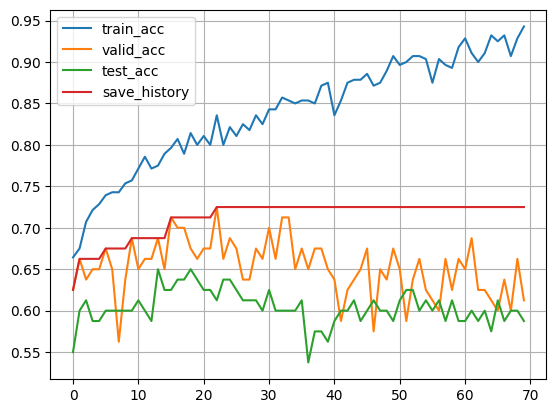

Finished Training


In [35]:
month_count = 18
window_size = 16

end="2022-06-01"
tickers = ["EBAY"]

test_month_count = 2
valid_month_count = 2

mon_res = test_month_count + valid_month_count

start = (parse(end) - relativedelta(months=mon_res+month_count)).strftime("%Y-%m-%d")
test_coef = mon_res / (mon_res + month_count)

train_dataloader, valid_dataloader, test_dataloader, X_train, y_train, X_valid, y_valid, X_test, y_test, y_test_price = get_data(tickers, 
                                                                          end=end, 
                                                                          start=start, 
                                                                          test_coef=test_coef, 
                                                                          window_size=window_size,
                                                                          pipeline=process.HistBinPipeline)
mt = ModelTrainer(window_size)
mt.train_model(train_dataloader, valid_dataloader, test_dataloader, epoch=70)
model_ebay = mt.best_model

In [39]:
# tmodel = TorchModel(model, params['wsize'])
tickers = ["EBAY"]
emodel = TorchModel(model_ebay, window_size)

byt = market.BinYearTest(tickers, process.HistBinPipeline, end_date=None, window_size=window_size)
# orig_stdout = sys.stdout
# orig_stderr = sys.stderr
# f = open(os.devnull, 'w')
# sys.stdout = f
# sys.stderr = f
year_test_df = byt.trade(emodel)
# sys.stdout = orig_stdout
# sys.stderr = orig_stderr

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


In [40]:
year_test_df

Month  TrainAcc   TestAcc    Income  Potential
0   Jun_2022  0.586498  0.687500  1.107338   0.752218
1   Jul_2022  0.481013  0.529412  0.999335  -0.004525
2   Aug_2022  0.555085  0.722222  1.007705   0.098014
3   Sep_2022  0.544304  0.444444  0.900054  -1.121173
4   Oct_2022  0.489451  0.722222  1.059782   0.950745
5   Nov_2022  0.580508  0.529412  1.036525   0.232189
6   Dec_2022  0.582278  0.611111  1.026159   0.303792
7   Jan_2023  0.523207  0.600000  1.021132   0.169396
8   Feb_2023  0.572034  0.625000  0.985315  -0.261417
9   Mar_2023  0.567797  0.666667  1.019072   0.287216
10  Apr_2023  0.610169  0.666667  1.069832   0.708645
11  May_2023  0.574468  0.588235  1.040071   0.656214

In [41]:
from functools import reduce
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print("Year capital multiplier", reduced_income)
reduced_income

Year capital multiplier 1.2907581222269173


1.2907581222269173

In [53]:
tickers = ["ALGN"]

byt = market.BinYearTest(tickers, process.HistBinPipeline, end_date=None, window_size=window_size)
year_test_df = byt.trade(tmodel)
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print("Year capital multiplier", reduced_income)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Year capital multiplier 1.0611842401972877


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[70,    10] loss: 0.256 | test acc: 0.637 | valid acc: 0.475 | train acc 0.939

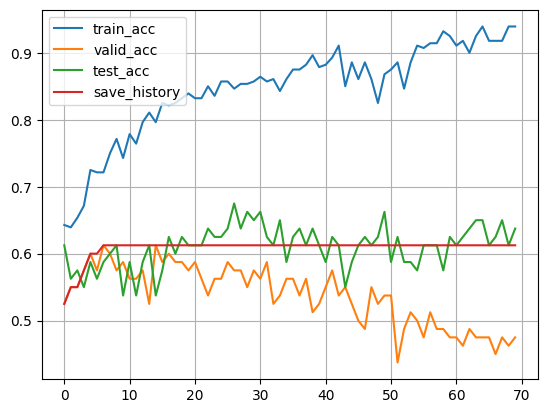

Finished Training


In [54]:
month_count = 18
window_size = 16

end="2022-06-01"

test_month_count = 2
valid_month_count = 2

mon_res = test_month_count + valid_month_count

start = (parse(end) - relativedelta(months=mon_res+month_count)).strftime("%Y-%m-%d")
test_coef = mon_res / (mon_res + month_count)

train_dataloader, valid_dataloader, test_dataloader, X_train, y_train, X_valid, y_valid, X_test, y_test, y_test_price = get_data(tickers, 
                                                                          end=end, 
                                                                          start=start, 
                                                                          test_coef=test_coef, 
                                                                          window_size=window_size,
                                                                          pipeline=process.HistBinPipeline)
mt = ModelTrainer(window_size)
mt.train_model(train_dataloader, valid_dataloader, test_dataloader, epoch=70)
model_algn = mt.best_model

In [55]:
amodel = TorchModel(model_algn, window_size)

byt = market.BinYearTest(tickers, process.HistBinPipeline, end_date=None, window_size=window_size)
year_test_df = byt.trade(amodel)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


In [57]:
year_test_df

Month  TrainAcc   TestAcc    Income  Potential
0   Jun_2022  0.611814  0.562500  1.019814   0.198566
1   Jul_2022  0.637131  0.529412  1.105016   0.570812
2   Aug_2022  0.588983  0.500000  0.998116  -0.015154
3   Sep_2022  0.624473  0.777778  1.072966   0.636249
4   Oct_2022  0.582278  0.444444  1.046345   0.223800
5   Nov_2022  0.593220  0.411765  1.061227   0.332927
6   Dec_2022  0.632911  0.611111  1.040863   0.267133
7   Jan_2023  0.582278  0.600000  1.100757   0.744067
8   Feb_2023  0.584746  0.562500  0.970365  -0.430332
9   Mar_2023  0.601695  0.666667  1.007454   0.099961
10  Apr_2023  0.631356  0.666667  1.056909   0.350927
11  May_2023  0.634043  0.647059  1.043356   0.524279

In [56]:
from functools import reduce
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print("Year capital multiplier", reduced_income)

Year capital multiplier 1.6552188756501656


### Multi-stocks

In [58]:
# for pandas future deprecated
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

import copy

CHANNELS = 5

def grid_search_multistock_cnn(window_sizes = [14,15,16], month_counts=[24]):
    tickers = ["CMCSA", "EBAY", "ALGN"]
    end="2022-06-01"
    max_cap = 0
    best_params = None
    best_global_model = None
    
    grid = [[None for i in range(len(month_counts))] for j in range(len(window_sizes))]
    
    for i, window_size in enumerate(window_sizes):
        for j, month_count in enumerate(month_counts):
            start = (parse(end) - relativedelta(months=12+month_count)).strftime("%Y-%m-%d")
            test_coef = 12 / (12 + month_count)
            
            X_train_glob = None
            X_test_glob = None
            y_train_glob = None
            y_test_glob = None
            y_test_prices = []
            X_tests = []
            for ticker in tickers:
                train_dataloader, _, test_dataloader, X_train, y_train, X_valid, y_valid, X_test, y_test, y_test_price = get_data([ticker], 
                                                                                      end=end, 
                                                                                      start=start, 
                                                                                      test_coef=test_coef, 
                                                                                      window_size=window_size,
                                                                                      pipeline=process.HistBinPipeline0Valid)
                X_train_glob = pd.concat([X_train_glob, X_train], ignore_index=True)
                X_test_glob = pd.concat([X_test_glob, X_test], ignore_index=True)
                y_train_glob = pd.concat([y_train_glob, y_train], ignore_index=True)
                y_test_glob = pd.concat([y_test_glob, y_test], ignore_index=True)
                y_test_prices.append(y_test_price)
                X_tests.append(X_test)
                
            training_data = CustomStockDataset(X_train_glob, y_train_glob)
            train_dataloader = DataLoader(training_data, batch_size=8, shuffle=False, drop_last=True)
            
            testing_data = CustomStockDataset(X_test_glob, y_test_glob)
            test_dataloader = DataLoader(testing_data, batch_size=8, shuffle=False, drop_last=True)
            
            mt = ModelTrainer(window_size)
            mt.train_model(train_dataloader, test_dataloader, test_dataloader, epoch=80)
            best_model = mt.best_model
            
            model = TorchModel(best_model, window_size)
            
            new_cap = 0
            for k, X_test in enumerate(X_tests):
                y_train_pred_bin = model.predict(X_test)
                cap = 100000
                btt = market.BinTraderTest(cap, y_train_pred_bin, y_test_prices[k])
                new_cap += btt.trade()
            
            if new_cap > max_cap:
                max_cap = new_cap
                best_params = {"wsize": window_size, "mon": month_count, "cap": max_cap}
                best_global_model = best_model
            
            grid[i][j] = new_cap
            
            print(f"[INFO] {month_count}: from {start} to '2021-06-01'; test_coef: {test_coef}; {new_cap-cap*len(X_tests)}$")
    return (best_params, best_global_model, grid)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.456 | test acc: 0.659 | valid acc: 0.659 | train acc 0.772

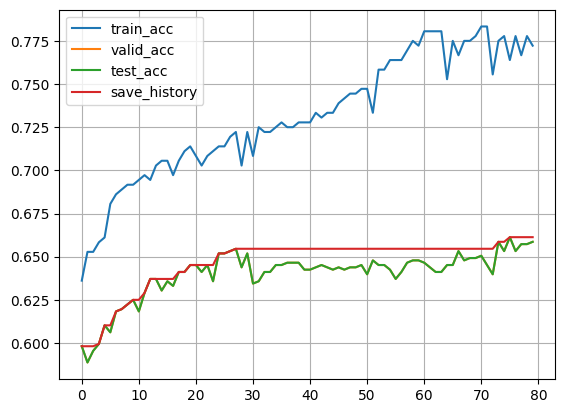

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [110696.06959242]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.533 | test acc: 0.571 | valid acc: 0.571 | train acc 0.739

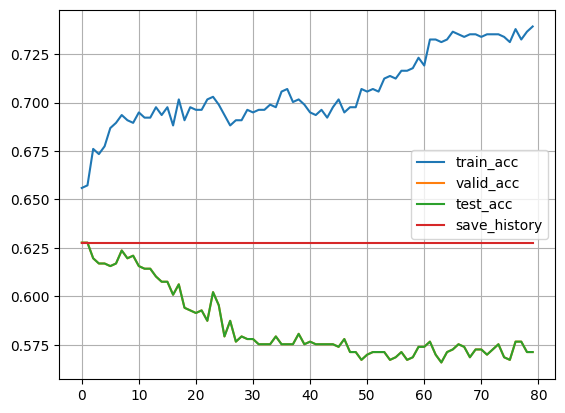

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [26493.50342738]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.527 | test acc: 0.538 | valid acc: 0.538 | train acc 0.696

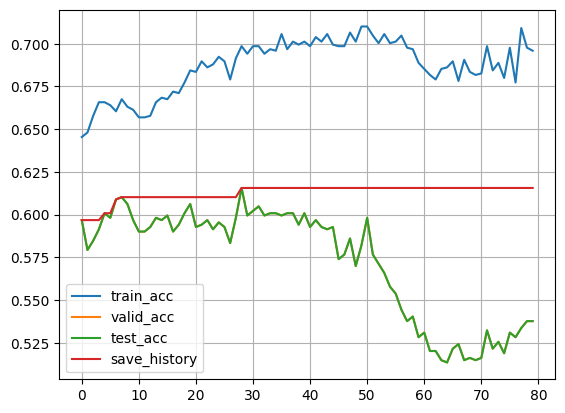

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [118161.14651991]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.558 | test acc: 0.573 | valid acc: 0.573 | train acc 0.690

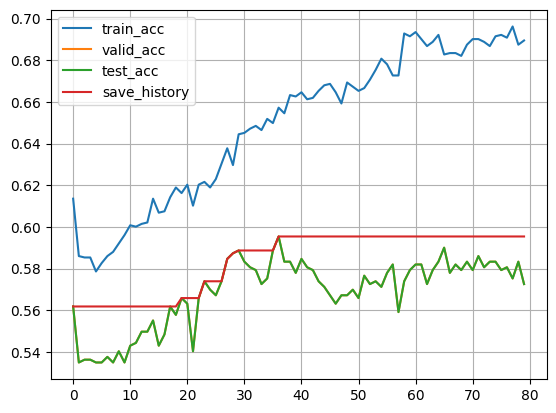

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [83322.49478502]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.554 | test acc: 0.610 | valid acc: 0.610 | train acc 0.705

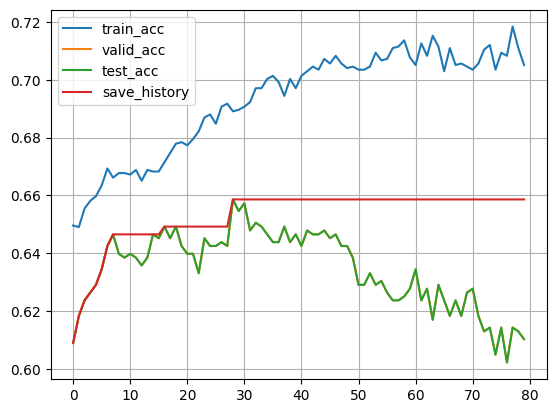

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [184596.47278051]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.257 | test acc: 0.622 | valid acc: 0.622 | train acc 0.864

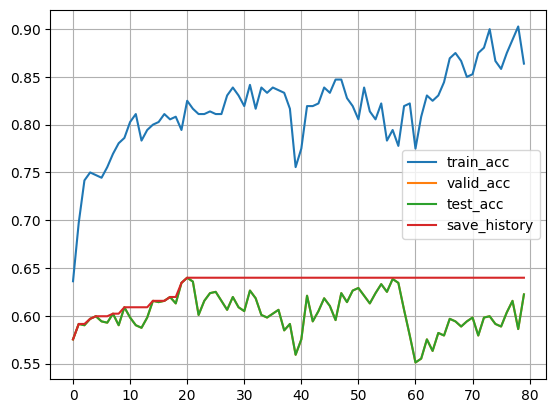

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [114581.11299294]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.391 | test acc: 0.579 | valid acc: 0.579 | train acc 0.788

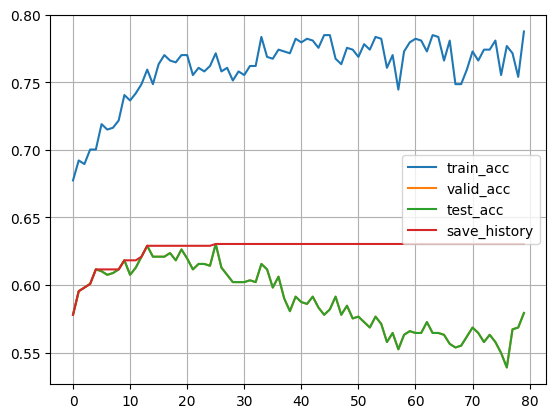

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [95192.46930238]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.437 | test acc: 0.523 | valid acc: 0.523 | train acc 0.711

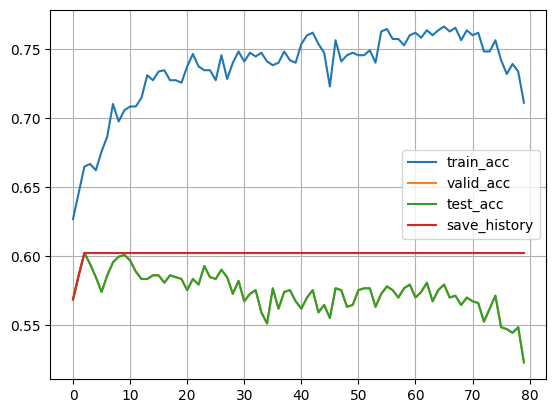

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [64050.14179601]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.444 | test acc: 0.531 | valid acc: 0.531 | train acc 0.761

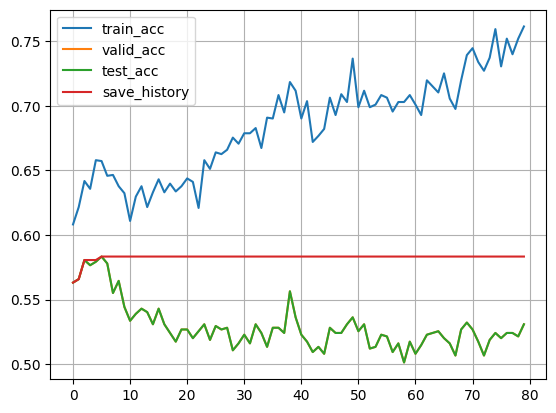

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [34154.81555969]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.498 | test acc: 0.613 | valid acc: 0.613 | train acc 0.744

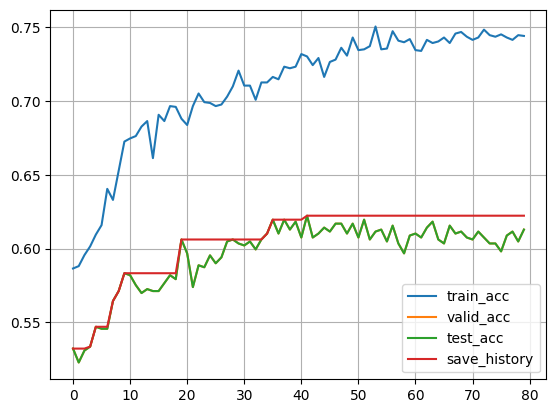

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [73157.30381154]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.315 | test acc: 0.557 | valid acc: 0.557 | train acc 0.825

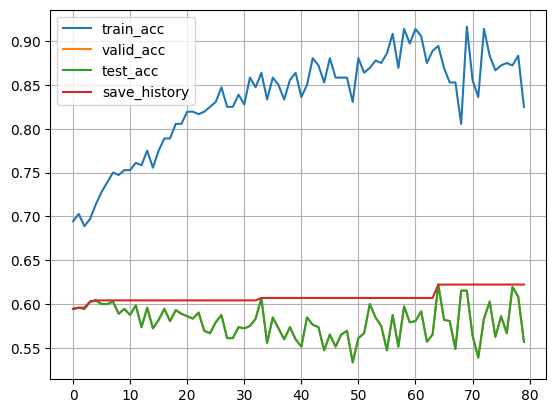

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [54191.22542153]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.366 | test acc: 0.573 | valid acc: 0.573 | train acc 0.836

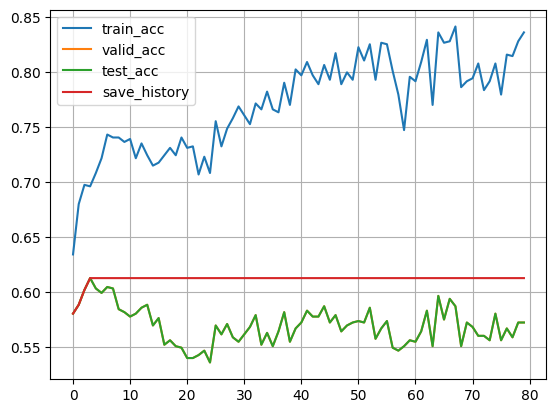

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [114892.50710109]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.437 | test acc: 0.586 | valid acc: 0.586 | train acc 0.770

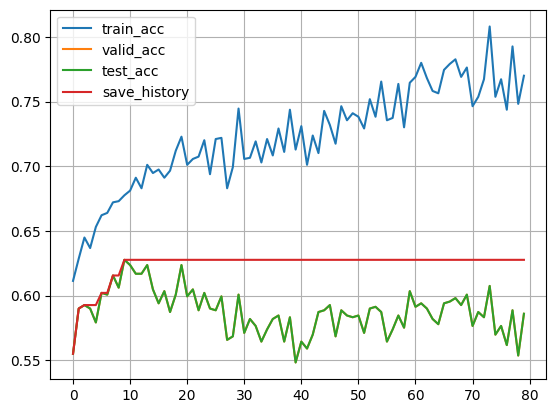

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [90774.32739737]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.482 | test acc: 0.597 | valid acc: 0.597 | train acc 0.779

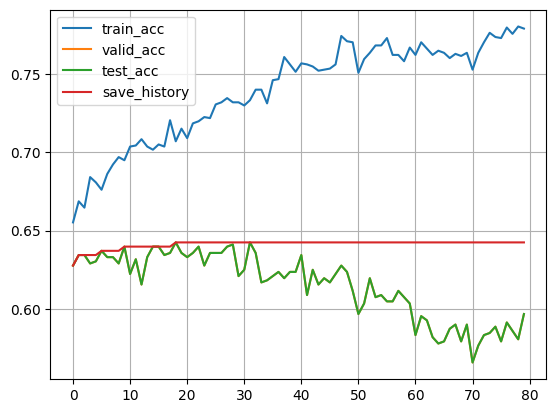

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [98460.68207227]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.532 | test acc: 0.621 | valid acc: 0.621 | train acc 0.756

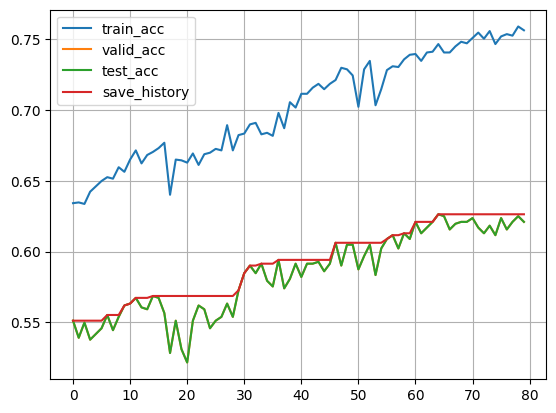

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [81726.58114729]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.240 | test acc: 0.647 | valid acc: 0.647 | train acc 0.936

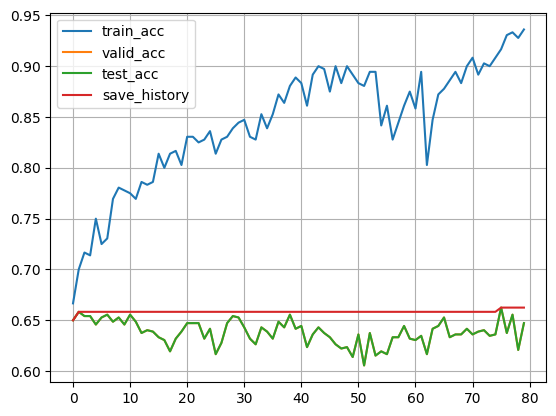

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [97355.02881716]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.441 | test acc: 0.593 | valid acc: 0.593 | train acc 0.800

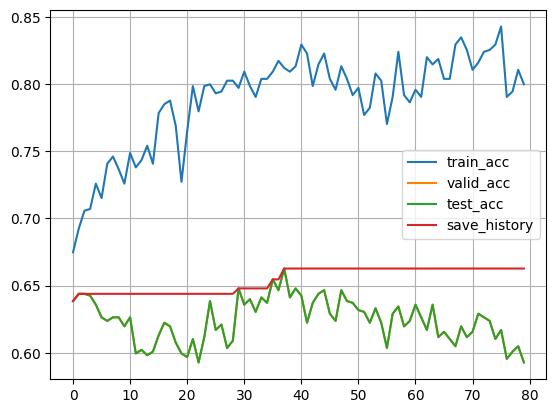

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [166546.80332353]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.394 | test acc: 0.628 | valid acc: 0.628 | train acc 0.808

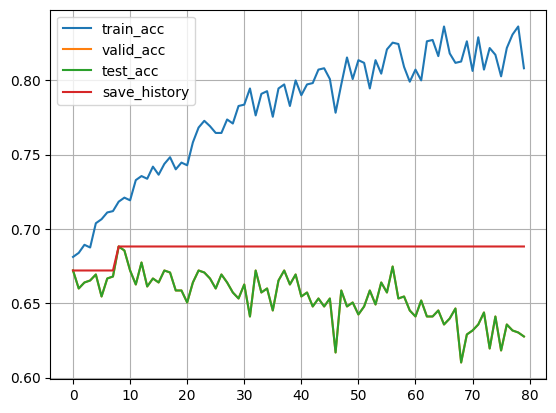

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [213321.60528196]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.481 | test acc: 0.612 | valid acc: 0.612 | train acc 0.776

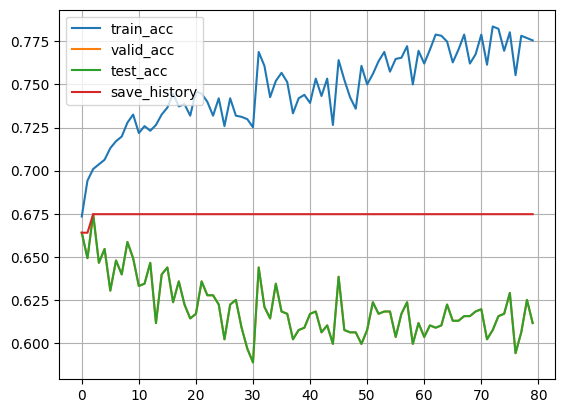

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [85065.69957654]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.465 | test acc: 0.617 | valid acc: 0.617 | train acc 0.755

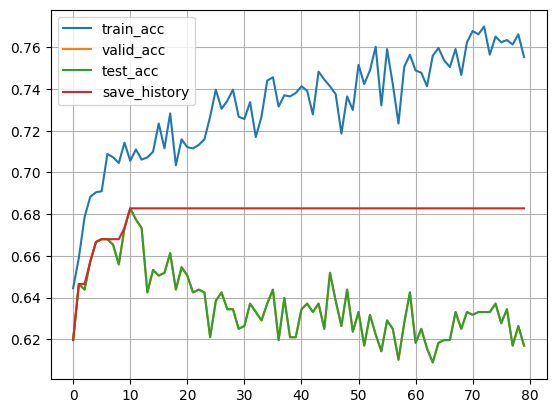

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [84675.22804884]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.298 | test acc: 0.607 | valid acc: 0.607 | train acc 0.886

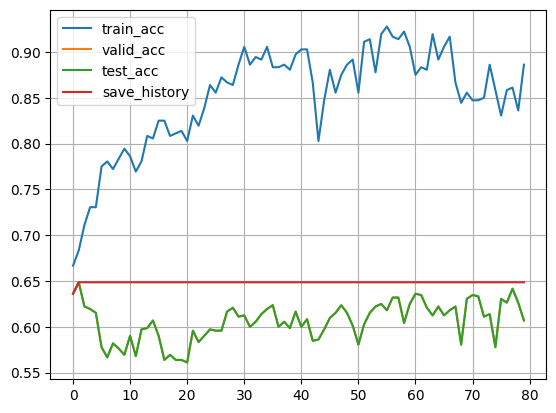

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [41381.60895134]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.399 | test acc: 0.647 | valid acc: 0.647 | train acc 0.812

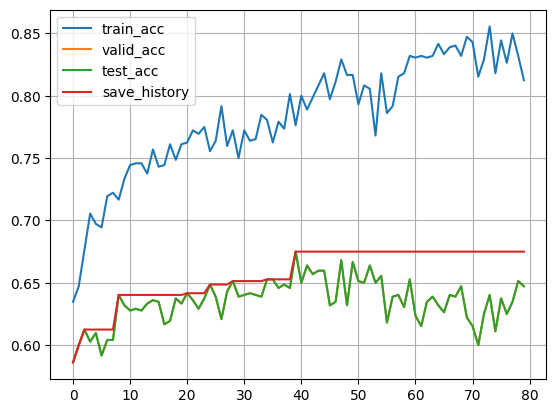

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [164215.74811241]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.397 | test acc: 0.613 | valid acc: 0.613 | train acc 0.829

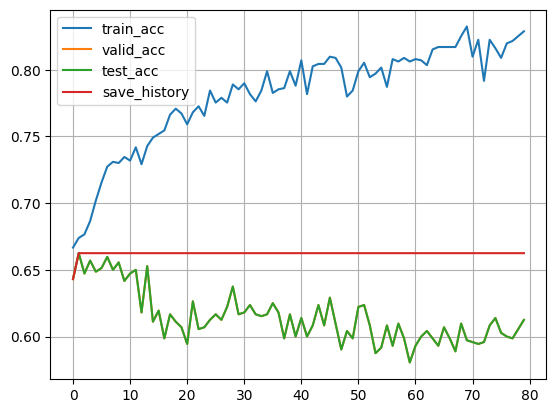

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [152390.42552838]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.481 | test acc: 0.626 | valid acc: 0.626 | train acc 0.799

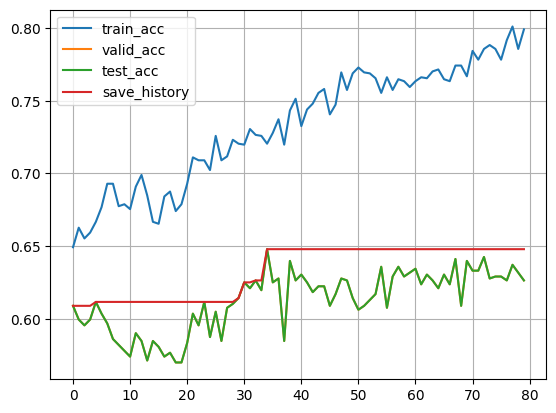

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [121024.24017041]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.503 | test acc: 0.647 | valid acc: 0.647 | train acc 0.761

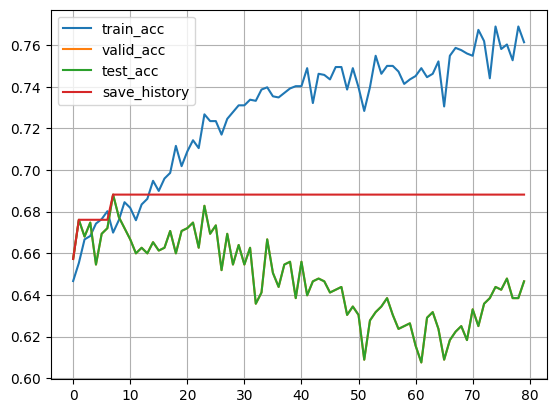

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [68074.86948575]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.312 | test acc: 0.603 | valid acc: 0.603 | train acc 0.894

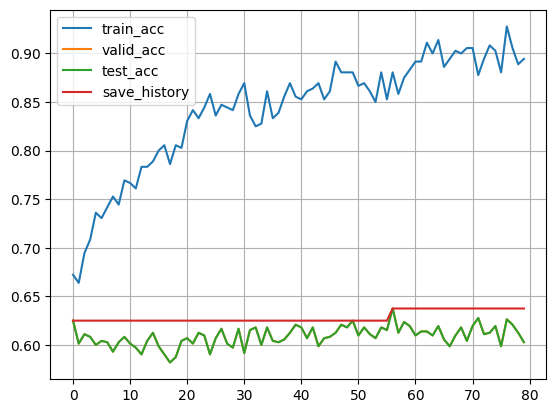

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [65579.50228932]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.451 | test acc: 0.607 | valid acc: 0.607 | train acc 0.814

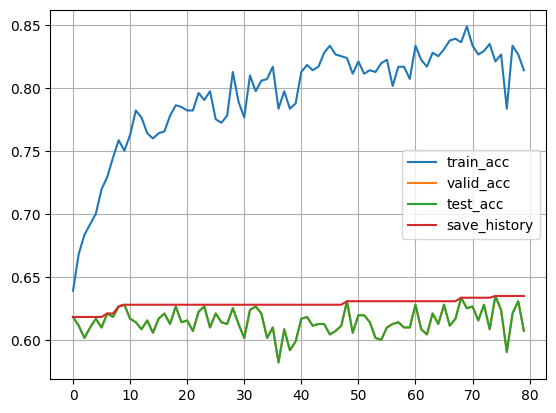

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [56118.37226263]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.409 | test acc: 0.628 | valid acc: 0.628 | train acc 0.834

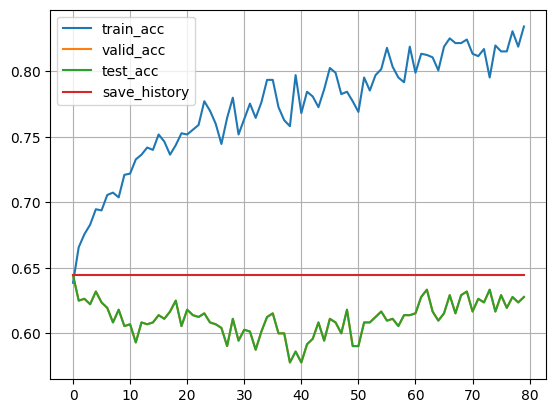

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [119854.25885808]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    93] loss: 0.511 | test acc: 0.637 | valid acc: 0.637 | train acc 0.755

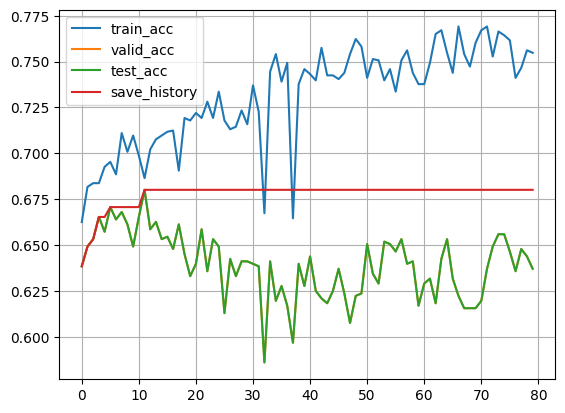

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [151787.33204302]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.488 | test acc: 0.651 | valid acc: 0.651 | train acc 0.779

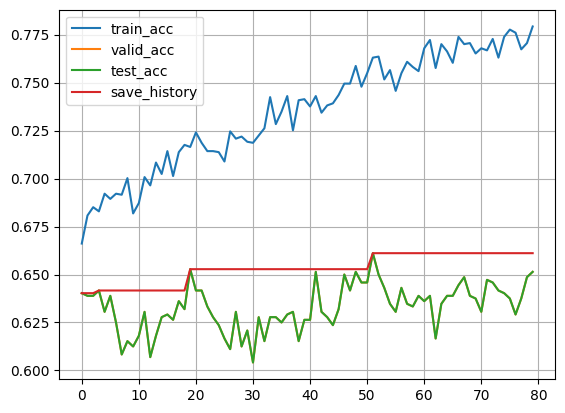

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [97225.39409676]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.277 | test acc: 0.626 | valid acc: 0.626 | train acc 0.911

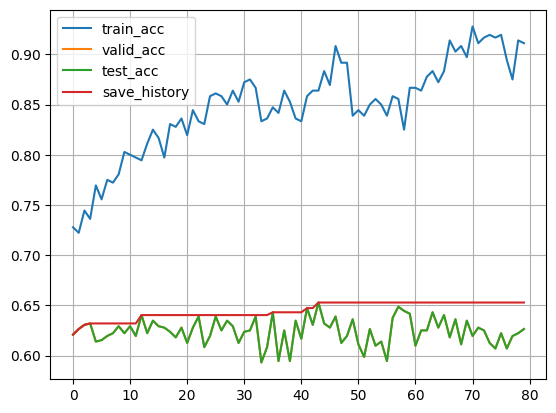

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [116620.08228347]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.438 | test acc: 0.653 | valid acc: 0.653 | train acc 0.810

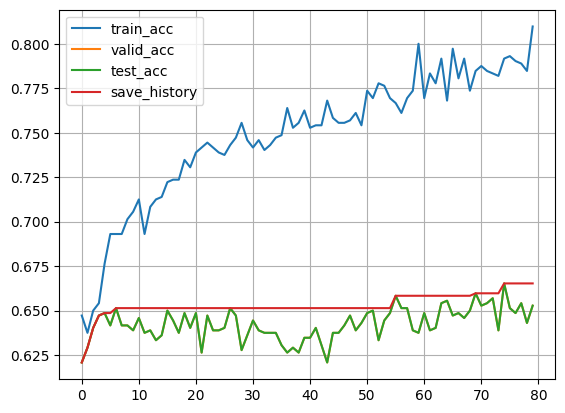

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [85902.55398788]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.465 | test acc: 0.637 | valid acc: 0.637 | train acc 0.784

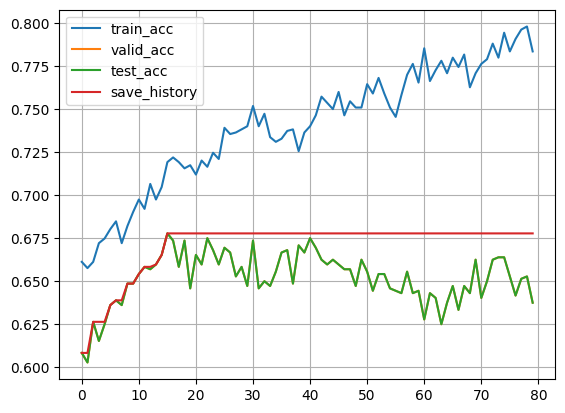

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [101150.87145093]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.486 | test acc: 0.637 | valid acc: 0.637 | train acc 0.773

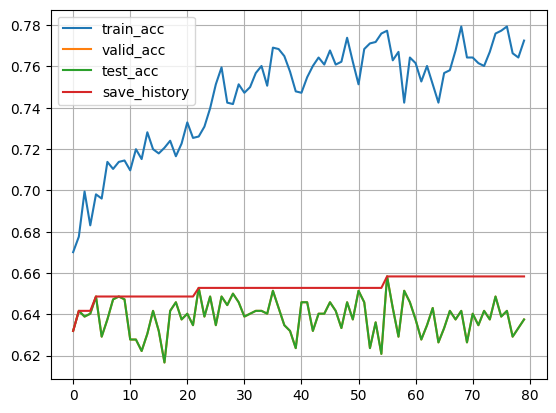

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [94366.86893805]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.519 | test acc: 0.643 | valid acc: 0.643 | train acc 0.756

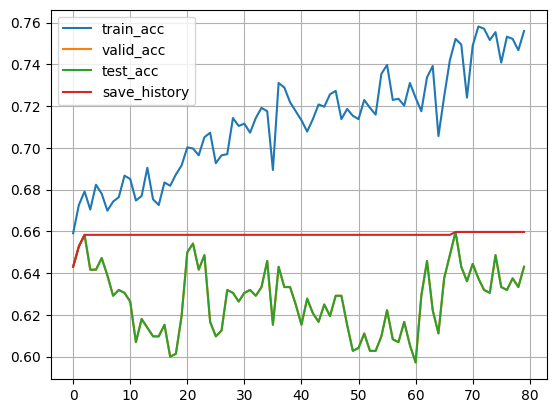

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [63042.06288451]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.339 | test acc: 0.617 | valid acc: 0.617 | train acc 0.850

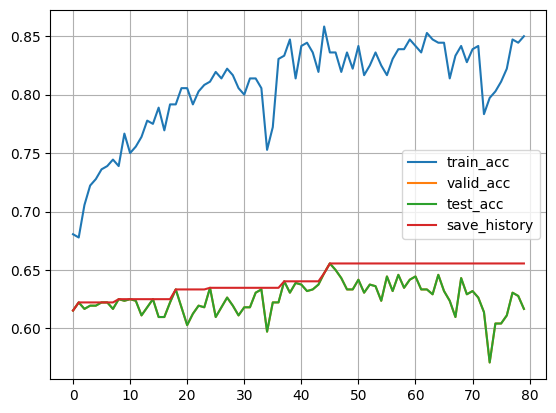

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [113292.07712141]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.405 | test acc: 0.635 | valid acc: 0.635 | train acc 0.831

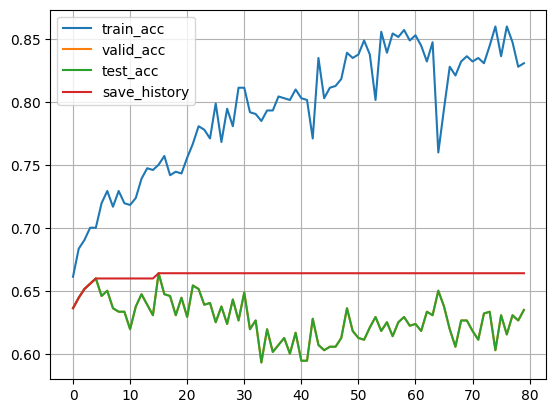

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [84707.27102095]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.450 | test acc: 0.651 | valid acc: 0.651 | train acc 0.813

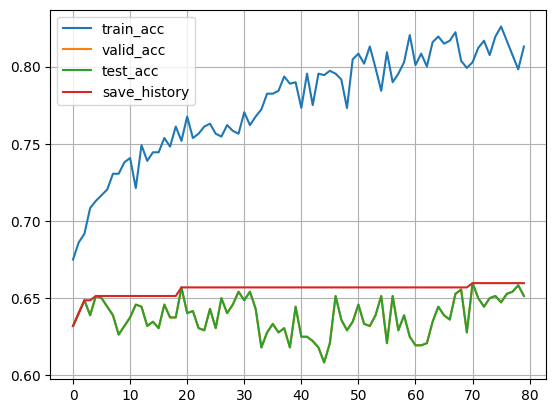

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [82665.1881006]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.498 | test acc: 0.622 | valid acc: 0.622 | train acc 0.769

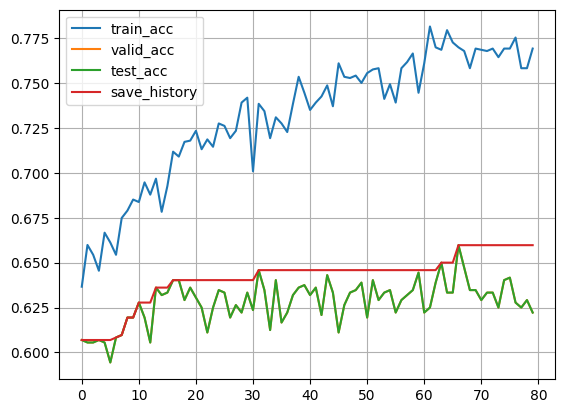

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [66970.21107998]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.539 | test acc: 0.628 | valid acc: 0.628 | train acc 0.734

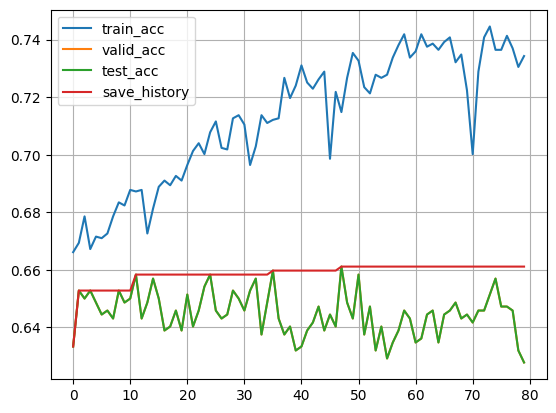

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [118198.38378435]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    87] loss: 0.336 | test acc: 0.636 | valid acc: 0.636 | train acc 0.863

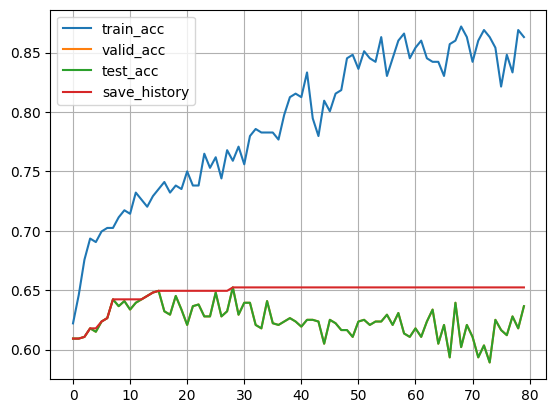

Finished Training
[INFO] 6: from 2020-12-01 to '2021-06-01'; test_coef: 0.6666666666666666; [112296.15126193]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.480 | test acc: 0.615 | valid acc: 0.615 | train acc 0.806

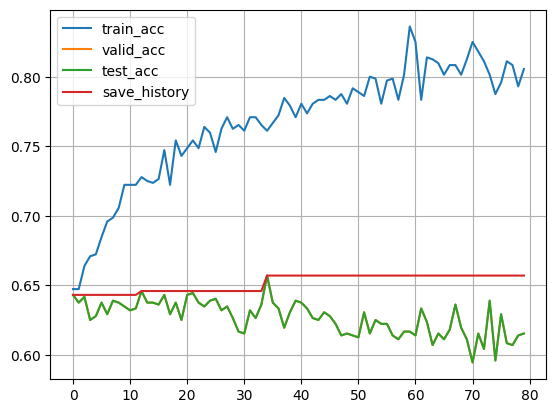

Finished Training
[INFO] 12: from 2020-06-01 to '2021-06-01'; test_coef: 0.5; [56911.2479696]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.401 | test acc: 0.635 | valid acc: 0.635 | train acc 0.814

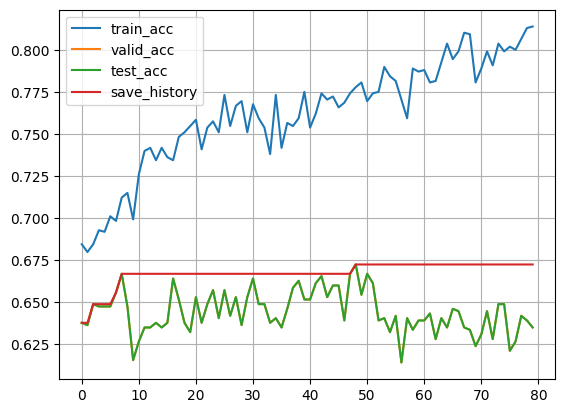

Finished Training
[INFO] 18: from 2019-12-01 to '2021-06-01'; test_coef: 0.4; [122239.89573767]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.518 | test acc: 0.637 | valid acc: 0.637 | train acc 0.766

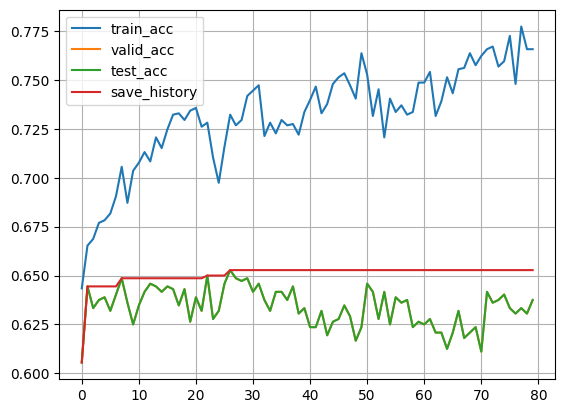

Finished Training
[INFO] 24: from 2019-06-01 to '2021-06-01'; test_coef: 0.3333333333333333; [121013.47328601]$
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[80,    90] loss: 0.507 | test acc: 0.649 | valid acc: 0.649 | train acc 0.778

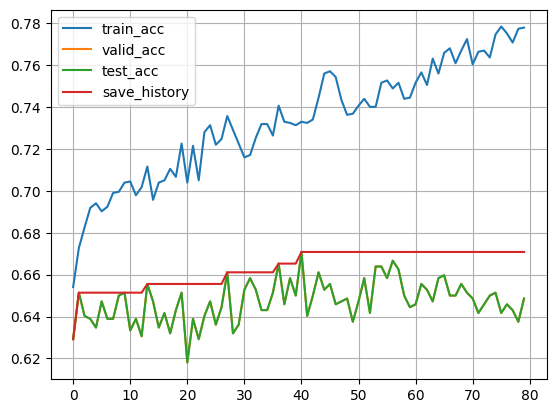

Finished Training
[INFO] 30: from 2018-12-01 to '2021-06-01'; test_coef: 0.2857142857142857; [151264.77845099]$


In [59]:
window_sizes = [i for i in range(4, 21, 2)]
month_counts = [6, 12, 18, 24, 30]

params, model, grid = grid_search_multistock_cnn(window_sizes, month_counts)

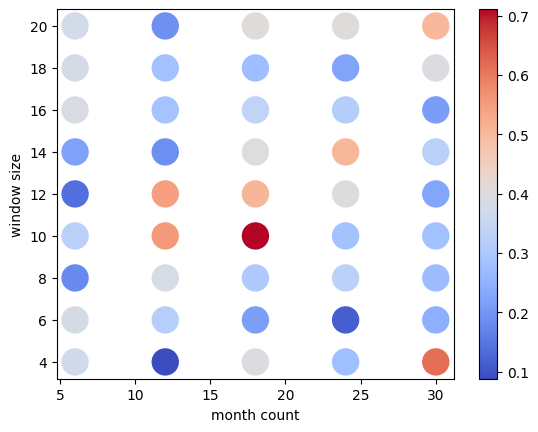

In [66]:
from matplotlib import cm
import numpy as np

fig = plt.figure()
plt.xlabel("month count")
plt.ylabel("window size")
# plt.contourf(month_counts, window_sizes, ( (np.array(grid) - 100000) / 100000 ).squeeze(), cmap=cm.coolwarm)
y = []
for item in window_sizes:
    y.append([item] * len(month_counts))
plt.scatter(month_counts*len(window_sizes), y, c=( (np.array(grid) - 300000) / 300000 ).squeeze(), s=350, cmap=cm.coolwarm)
plt.colorbar()

In [65]:
params

{'wsize': 10, 'mon': 18, 'cap': array([513321.60528196])}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[70,    30] loss: 0.457 | test acc: 0.558 | valid acc: 0.592 | train acc 0.804

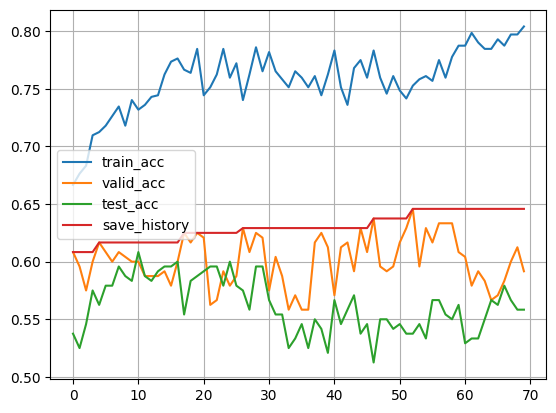

Finished Training


In [14]:
month_count = 16
window_size = 11

end="2022-06-01"

test_month_count = 2
valid_month_count = 2

mon_res = test_month_count + valid_month_count

start = (parse(end) - relativedelta(months=mon_res+month_count)).strftime("%Y-%m-%d")
test_coef = mon_res / (mon_res + month_count)

tickers = ["CMCSA", "EBAY", "ALGN"]


X_train_glob = None
X_valid_glob = None
X_test_glob = None
y_train_glob = None
y_valid_glob = None
y_test_glob = None
y_test_prices = []
X_tests = []
for ticker in tickers:
    train_dataloader, valid_dataloader, test_dataloader, X_train, y_train, X_valid, y_valid, X_test, y_test, y_test_price = get_data([ticker], 
                                                                          end=end, 
                                                                          start=start, 
                                                                          test_coef=test_coef, 
                                                                          window_size=window_size,
                                                                          pipeline=process.HistBinPipeline)
    X_train_glob = pd.concat([X_train_glob, X_train], ignore_index=True)
    X_valid_glob = pd.concat([X_valid_glob, X_valid], ignore_index=True)
    X_test_glob = pd.concat([X_test_glob, X_test], ignore_index=True)
    y_train_glob = pd.concat([y_train_glob, y_train], ignore_index=True)
    y_valid_glob = pd.concat([y_valid_glob, y_valid], ignore_index=True)
    y_test_glob = pd.concat([y_test_glob, y_test], ignore_index=True)
    y_test_prices.append(y_test_price)
    X_tests.append(X_test)
    
training_data = CustomStockDataset(X_train_glob, y_train_glob)
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=False, drop_last=True)

valid_data = CustomStockDataset(X_valid_glob, y_valid_glob)
valid_dataloader = DataLoader(valid_data, batch_size=8, shuffle=False, drop_last=True)

testing_data = CustomStockDataset(X_test_glob, y_test_glob)
test_dataloader = DataLoader(testing_data, batch_size=8, shuffle=False, drop_last=True)
                
                
mt = ModelTrainer(window_size)
mt.train_model(train_dataloader, valid_dataloader, test_dataloader, epoch=70)
model_multi = mt.best_model


mmodel = TorchModel(model_multi, window_size)

In [15]:
from functools import reduce
total = ""
for ticker in tickers:
    byt = market.BinYearTest([ticker], process.HistBinPipeline, end_date=None, window_size=window_size)
    year_test_df = byt.trade(mmodel)
    items = list(year_test_df["Income"])
    reduced_income = reduce(lambda a,b: a*b, items)
    total += f"Year capital multiplier {ticker} {reduced_income}\n"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()
C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


In [16]:
print(total)

Year capital multiplier CMCSA 0.976203715756995
Year capital multiplier EBAY 1.1340695982183762
Year capital multiplier ALGN 1.2398274501670514

